# <center> 👉 class_13_5 » _OpenPose vs MediaPipe_ </center>

## ▣ OpenPose for Multi and MediaPipe for Singular 

In [1]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## ▶ Specify the model to be used  

COCO and MPI are body pose estimation model.   
- COCO has 18 points and 
- MPI has 15 points as output.

HAND is hand keypoints estimation model.   
- It has 22 points as output

Ensure that the model files are available in the folders.

In [2]:
MODE = "MPI"

if MODE is "COCO":
    protoFile = "./pose_est/coco/coco_pose_deploy_linevec.prototxt"
    weightsFile = "./pose_est/coco_pose_iter_440000.caffemodel"
    nPoints = 18
    POSE_PAIRS = [ [1,0],[1,2],[1,5],[2,3],[3,4],[5,6],[6,7],[1,8],[8,9],[9,10],[1,11],[11,12],[12,13],[0,14],[0,15],[14,16],[15,17]]

elif MODE is "MPI" :
    protoFile = "./pose_est/mpi/mpi_pose_deploy_linevec_faster_4_stages.prototxt"
    weightsFile = "./pose_est/mpi_pose_iter_160000.caffemodel"
    nPoints = 15
    POSE_PAIRS = [[0,1], [1,2], [2,3], [3,4], [1,5], [5,6], [6,7], [1,14], [14,8], [8,9], [9,10], [14,11], [11,12], [12,13] ]
    

Next, load an image with multiple people and check what the model sees

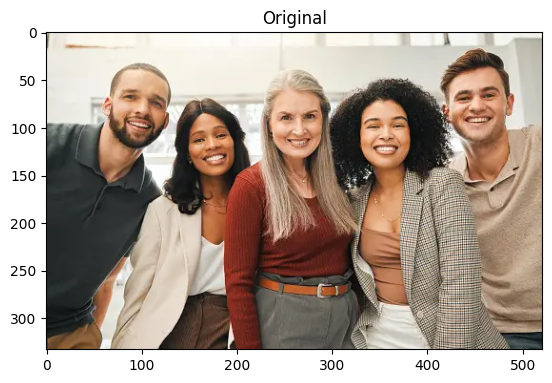

In [3]:
image1 = cv2.imread("./images/CV/people6.webp")
frameWidth = image1.shape[1]
frameHeight = image1.shape[0]
threshold = 0.1

plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.title('Original')
plt.show()

Load the network and pass the image through the network

In [4]:
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

inWidth = 368
inHeight = 368
inpBlob = cv2.dnn.blobFromImage(image1, 1.0 / 255, (inWidth, inHeight),
                          (0, 0, 0), swapRB=False, crop=False)

net.setInput(inpBlob)
output = net.forward()
H = output.shape[2]
W = output.shape[3]
print(output.shape)

(1, 44, 46, 46)


Slice a probability map from the output for a specific keypoint and plot the heatmap (after resizing) on the image itself

(-0.5, 520.5, 332.5, -0.5)

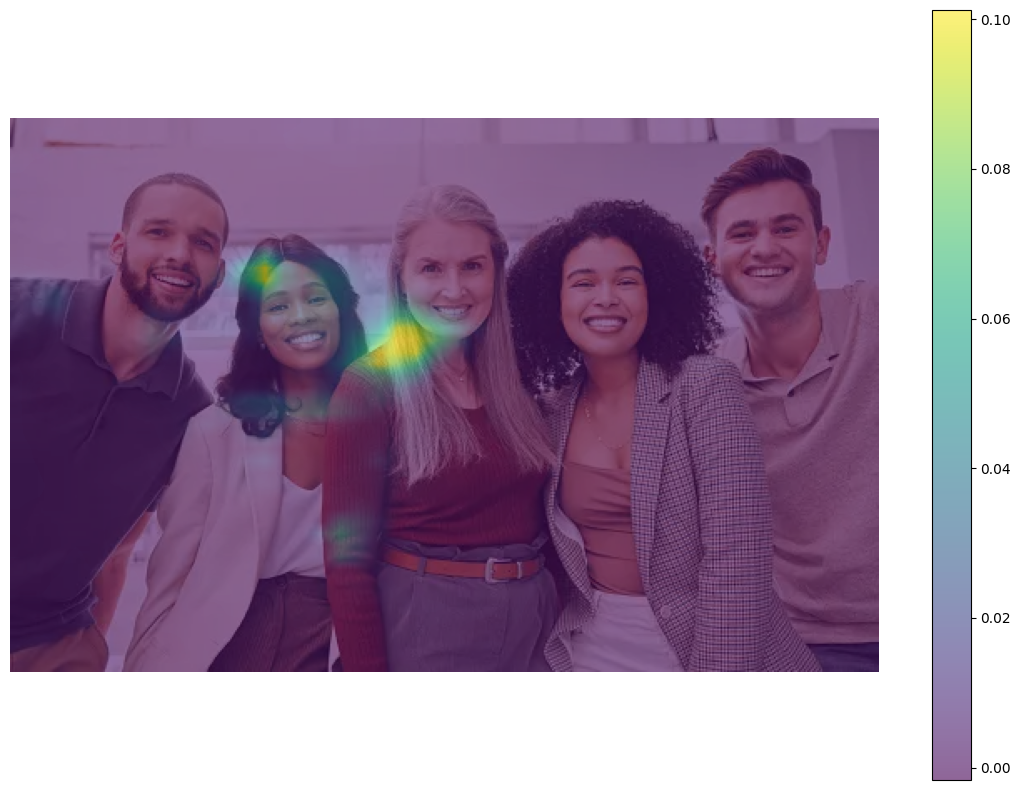

In [5]:
i = 5
probMap = output[0, i, :, :]
probMap = cv2.resize(probMap, (image1.shape[1], image1.shape[0]))
plt.figure(figsize=[14,10])
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.imshow(probMap, alpha=0.6)
plt.colorbar()
plt.axis("off")

Similarly plot the affinity map on the image

(-0.5, 520.5, 332.5, -0.5)

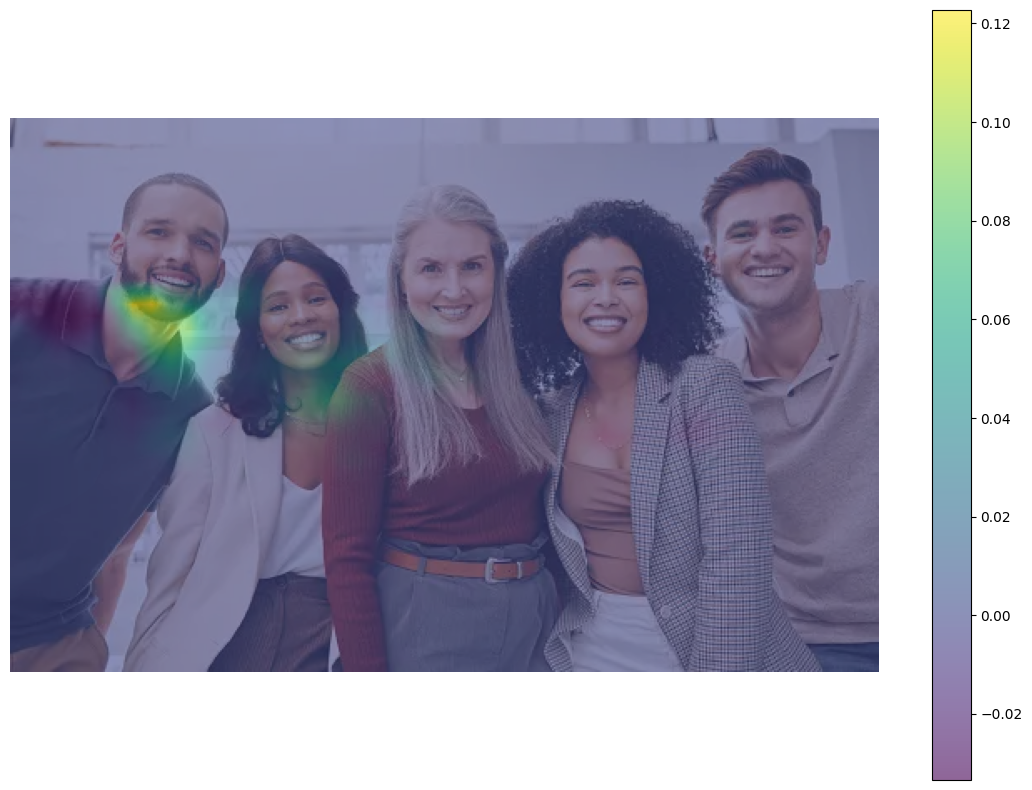

In [6]:
i = 24
probMap = output[0, i, :, :]
probMap = cv2.resize(probMap, (image1.shape[1], image1.shape[0]))
plt.figure(figsize=[14,10])
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.imshow(probMap, alpha=0.6)
plt.colorbar()
plt.axis("off")

### Next, we find the keypoints for a image with only single person

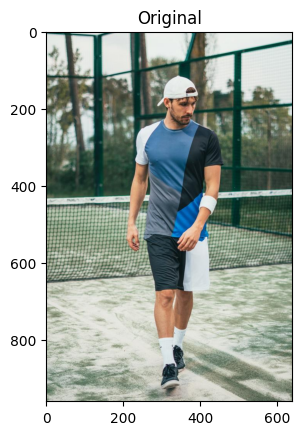

In [7]:
frame = cv2.imread("./images/CV/single.jpeg")
frameCopy = np.copy(frame)
frameWidth = frame.shape[1]
frameHeight = frame.shape[0]
threshold = 0.1

plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.title('Original')
plt.show()

In [8]:
# Pass it through the network

inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                          (0, 0, 0), swapRB=False, crop=False)
net.setInput(inpBlob)
output = net.forward()
H = output.shape[2]
W = output.shape[3]

gather the points and plot the keypoints and the skeleton figure

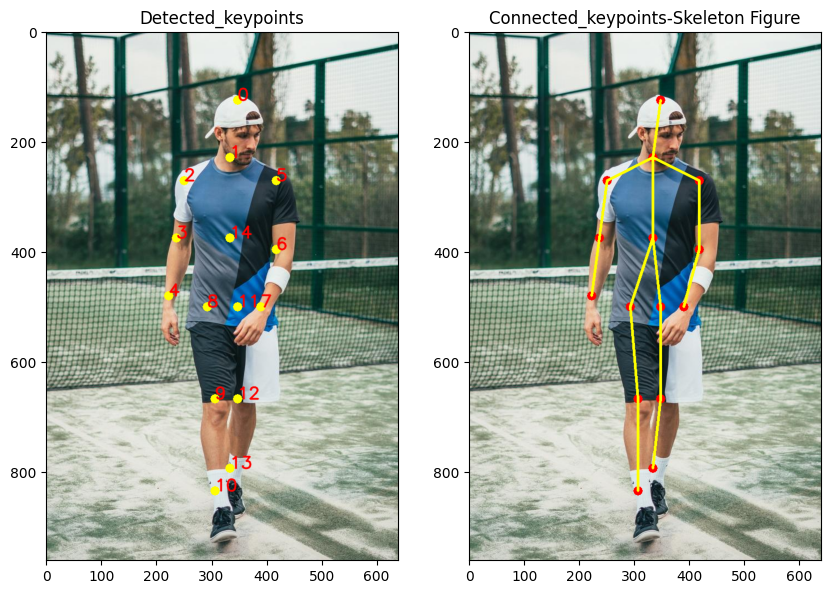

In [10]:
# Empty list to store the detected keypoints
points = []

for i in range(nPoints):
    # confidence map of corresponding body's part.
    probMap = output[0, i, :, :]

    # Find global maxima of the probMap.
    minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
    
    # Scale the point to fit on the original image
    x = (frameWidth * point[0]) / W
    y = (frameHeight * point[1]) / H

    if prob > threshold : 
        cv2.circle(frameCopy, (int(x), int(y)), 8, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
        cv2.putText(frameCopy, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, lineType=cv2.LINE_AA)
        cv2.circle(frame, (int(x), int(y)), 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)

        # Add the point to the list if the probability is greater than the threshold
        points.append((int(x), int(y)))
    else :
        points.append(None)

# Draw Skeleton
for pair in POSE_PAIRS:
    partA = pair[0]
    partB = pair[1]

    if points[partA] and points[partB]:
        cv2.line(frame, points[partA], points[partB], (0, 255, 255), 3)

plt.figure(figsize=[10,10])
plt.subplot(121),plt.imshow(cv2.cvtColor(frameCopy, cv2.COLOR_BGR2RGB)),plt.title('Detected_keypoints')
plt.subplot(122),plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)),plt.title('Connected_keypoints-Skeleton Figure')
plt.show()

## ▣ Real Time Video MediaPipe vs OpenPose w/ COCO vs MPI

In [11]:
# mp
import cv2
import mediapipe as mp
import time

mpPose = mp.solutions.pose
pose = mpPose.Pose()
mpDraw = mp.solutions.drawing_utils

#cap = cv2.VideoCapture(0)
cap = cv2.VideoCapture('./Videos/pose_sample_video.mp4')
# cap = cv2.VideoCapture('./Videos/people_walk.mp4')
pTime = 0

while True:
    success, img = cap.read()
    imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_org = imgRGB.copy()
    results = pose.process(imgRGB)
#     print(results.pose_landmarks)
    if results.pose_landmarks:
        mpDraw.draw_landmarks(img, results.pose_landmarks, mpPose.POSE_CONNECTIONS)
        for id, lm in enumerate(results.pose_landmarks.landmark):
            h, w,c = img.shape
            print(id, lm)
            cx, cy = int(lm.x*w), int(lm.y*h)
            cv2.circle(img, (cx, cy), 5, (255,0,0), cv2.FILLED)

        cTime = time.time()
        fps = 1/(cTime-pTime)
        pTime = cTime

    cv2.putText(img, str(int(fps)), (50,50), cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,0), 3)
    cv2.imshow("Org", img_org)
    cv2.imshow("Image", img)
    if cv2.waitKey(10) & 0xFF == 27:
        break
cap.release()
cv2.destroyAllWindows()

0 x: 0.47922399640083313
y: 0.2386193871498108
z: -0.35171547532081604
visibility: 0.9999929666519165

1 x: 0.49101802706718445
y: 0.22797709703445435
z: -0.3339546322822571
visibility: 0.9999912977218628

2 x: 0.4984978437423706
y: 0.22744210064411163
z: -0.33397945761680603
visibility: 0.9999914169311523

3 x: 0.5059518814086914
y: 0.2267724573612213
z: -0.33405718207359314
visibility: 0.9999918937683105

4 x: 0.47549253702163696
y: 0.22959627211093903
z: -0.31535476446151733
visibility: 0.9999815225601196

5 x: 0.47157716751098633
y: 0.23029544949531555
z: -0.3152647316455841
visibility: 0.9999717473983765

6 x: 0.46816369891166687
y: 0.2310429960489273
z: -0.315268337726593
visibility: 0.999964714050293

7 x: 0.5262469053268433
y: 0.23683634400367737
z: -0.16986966133117676
visibility: 0.999984622001648

8 x: 0.479571670293808
y: 0.24147742986679077
z: -0.08814161270856857
visibility: 0.9999760389328003

9 x: 0.4969503581523895
y: 0.24954292178153992
z: -0.2882494628429413
visibili

0 x: 0.47080475091934204
y: 0.25364571809768677
z: -0.4065534770488739
visibility: 0.9999751448631287

1 x: 0.4856972098350525
y: 0.24230802059173584
z: -0.40460464358329773
visibility: 0.9999422430992126

2 x: 0.49111616611480713
y: 0.24203020334243774
z: -0.4045248329639435
visibility: 0.9999421238899231

3 x: 0.4964638352394104
y: 0.24181202054023743
z: -0.4044744670391083
visibility: 0.9999340772628784

4 x: 0.4776073694229126
y: 0.24366635084152222
z: -0.3790336549282074
visibility: 0.9999393820762634

5 x: 0.47689586877822876
y: 0.24418233335018158
z: -0.37918150424957275
visibility: 0.9999433755874634

6 x: 0.47596973180770874
y: 0.24462634325027466
z: -0.3791750967502594
visibility: 0.9999358654022217

7 x: 0.5217530727386475
y: 0.25340133905410767
z: -0.33050665259361267
visibility: 0.9998899102210999

8 x: 0.4905875027179718
y: 0.25597941875457764
z: -0.21683453023433685
visibility: 0.9998688101768494

9 x: 0.4842018485069275
y: 0.265376478433609
z: -0.3773828446865082
visibi

0 x: 0.4997783899307251
y: 0.240164652466774
z: -0.45013439655303955
visibility: 0.9999788999557495

1 x: 0.5130249261856079
y: 0.23166808485984802
z: -0.4233834147453308
visibility: 0.9999439120292664

2 x: 0.5201874375343323
y: 0.23179808259010315
z: -0.42349934577941895
visibility: 0.9999454021453857

3 x: 0.5276795625686646
y: 0.23210355639457703
z: -0.42356109619140625
visibility: 0.999938428401947

4 x: 0.49707114696502686
y: 0.23283426463603973
z: -0.4025680720806122
visibility: 0.9999440908432007

5 x: 0.49361732602119446
y: 0.23348265886306763
z: -0.40264081954956055
visibility: 0.9999492168426514

6 x: 0.48990318179130554
y: 0.23425592482089996
z: -0.40257877111434937
visibility: 0.99994295835495

7 x: 0.545691192150116
y: 0.24421736598014832
z: -0.2716853618621826
visibility: 0.9999096393585205

8 x: 0.49755382537841797
y: 0.24797053635120392
z: -0.20271120965480804
visibility: 0.9998696446418762

9 x: 0.5138168931007385
y: 0.25696641206741333
z: -0.39582058787345886
visibil

0 x: 0.5458126068115234
y: 0.23289911448955536
z: -0.25474944710731506
visibility: 0.9999842047691345

1 x: 0.5564332604408264
y: 0.22446545958518982
z: -0.21461927890777588
visibility: 0.9999554753303528

2 x: 0.5628684163093567
y: 0.2251022607088089
z: -0.21465468406677246
visibility: 0.9999565482139587

3 x: 0.5690467357635498
y: 0.2256445735692978
z: -0.2146805077791214
visibility: 0.9999535083770752

4 x: 0.5368034839630127
y: 0.22401724755764008
z: -0.21149176359176636
visibility: 0.9999542236328125

5 x: 0.5298917293548584
y: 0.22468799352645874
z: -0.21152740716934204
visibility: 0.9999569654464722

6 x: 0.5220526456832886
y: 0.22578468918800354
z: -0.21144449710845947
visibility: 0.9999523758888245

7 x: 0.5791218280792236
y: 0.2348451167345047
z: -0.025784999132156372
visibility: 0.9999343156814575

8 x: 0.5136040449142456
y: 0.23726783692836761
z: -0.010671359486877918
visibility: 0.9998847246170044

9 x: 0.5583285093307495
y: 0.25118568539619446
z: -0.18862490355968475
visi

0 x: 0.5634703636169434
y: 0.23389767110347748
z: -0.3596072494983673
visibility: 0.99998939037323

1 x: 0.5726611018180847
y: 0.2252805083990097
z: -0.31852227449417114
visibility: 0.999970018863678

2 x: 0.5790923237800598
y: 0.22573226690292358
z: -0.3184582591056824
visibility: 0.9999707341194153

3 x: 0.5860207080841064
y: 0.22610926628112793
z: -0.31849876046180725
visibility: 0.9999687671661377

4 x: 0.5537115931510925
y: 0.2252688705921173
z: -0.3248964846134186
visibility: 0.9999691247940063

5 x: 0.5464527606964111
y: 0.22590798139572144
z: -0.32474246621131897
visibility: 0.9999707937240601

6 x: 0.539025604724884
y: 0.22685593366622925
z: -0.3247360289096832
visibility: 0.9999678134918213

7 x: 0.5960942506790161
y: 0.23619893193244934
z: -0.1098002940416336
visibility: 0.9999553561210632

8 x: 0.5287864804267883
y: 0.23820480704307556
z: -0.15381042659282684
visibility: 0.9999237060546875

9 x: 0.5754815340042114
y: 0.25120440125465393
z: -0.2814272344112396
visibility: 0.

0 x: 0.5710813999176025
y: 0.23898808658123016
z: -0.24141937494277954
visibility: 0.9999908208847046

1 x: 0.5794196128845215
y: 0.22989344596862793
z: -0.20093317329883575
visibility: 0.9999765753746033

2 x: 0.5854017734527588
y: 0.22993680834770203
z: -0.20093341171741486
visibility: 0.9999768733978271

3 x: 0.5913165807723999
y: 0.22986575961112976
z: -0.20104506611824036
visibility: 0.9999758005142212

4 x: 0.5603837966918945
y: 0.23095935583114624
z: -0.20427155494689941
visibility: 0.9999740123748779

5 x: 0.5530223250389099
y: 0.2317301630973816
z: -0.20421430468559265
visibility: 0.9999725818634033

6 x: 0.5446014404296875
y: 0.23245394229888916
z: -0.2041579633951187
visibility: 0.9999706745147705

7 x: 0.6001107692718506
y: 0.23980242013931274
z: 0.020473454147577286
visibility: 0.9999626874923706

8 x: 0.533543586730957
y: 0.2438342571258545
z: -0.0016254918882623315
visibility: 0.9999440312385559

9 x: 0.5830205678939819
y: 0.2547650635242462
z: -0.16088643670082092
visib

0 x: 0.5735485553741455
y: 0.24429406225681305
z: -0.41543304920196533
visibility: 0.9999902248382568

1 x: 0.5811508893966675
y: 0.23401130735874176
z: -0.37534579634666443
visibility: 0.9999791979789734

2 x: 0.5876634120941162
y: 0.23414401710033417
z: -0.37532827258110046
visibility: 0.99997878074646

3 x: 0.5925411581993103
y: 0.23421946167945862
z: -0.37535420060157776
visibility: 0.9999780654907227

4 x: 0.5606728792190552
y: 0.23531457781791687
z: -0.3752729892730713
visibility: 0.9999750852584839

5 x: 0.5535794496536255
y: 0.23672938346862793
z: -0.375303715467453
visibility: 0.9999731183052063

6 x: 0.5463969707489014
y: 0.23827673494815826
z: -0.37517520785331726
visibility: 0.9999700784683228

7 x: 0.6006990671157837
y: 0.2438352108001709
z: -0.17608091235160828
visibility: 0.9999688863754272

8 x: 0.5389629006385803
y: 0.2500939965248108
z: -0.1769222468137741
visibility: 0.9999387860298157

9 x: 0.5882037878036499
y: 0.2616288661956787
z: -0.34435170888900757
visibility:

0 x: 0.615475594997406
y: 0.2425937056541443
z: -0.620774507522583
visibility: 0.9999917149543762

1 x: 0.6165527105331421
y: 0.23249980807304382
z: -0.579134464263916
visibility: 0.9999824166297913

2 x: 0.6202127933502197
y: 0.23256458342075348
z: -0.5792320370674133
visibility: 0.9999819993972778

3 x: 0.6238900423049927
y: 0.2326064258813858
z: -0.5793454647064209
visibility: 0.9999813437461853

4 x: 0.601111114025116
y: 0.23335352540016174
z: -0.5876495242118835
visibility: 0.9999784231185913

5 x: 0.5943208932876587
y: 0.23428694903850555
z: -0.5877359509468079
visibility: 0.9999774098396301

6 x: 0.5866435170173645
y: 0.2351037710905075
z: -0.5875917077064514
visibility: 0.9999749064445496

7 x: 0.6208550930023193
y: 0.24193161725997925
z: -0.34916844964027405
visibility: 0.9999753832817078

8 x: 0.5679911375045776
y: 0.24839939177036285
z: -0.3784761428833008
visibility: 0.9999430179595947

9 x: 0.6216639876365662
y: 0.258684903383255
z: -0.5350276231765747
visibility: 0.999988

0 x: 0.6324470639228821
y: 0.24429947137832642
z: -0.42396819591522217
visibility: 0.9999905228614807

1 x: 0.6318163275718689
y: 0.2336999624967575
z: -0.38144099712371826
visibility: 0.9999710917472839

2 x: 0.6348879337310791
y: 0.23395660519599915
z: -0.38158801198005676
visibility: 0.9999714493751526

3 x: 0.6376804113388062
y: 0.23420298099517822
z: -0.38167545199394226
visibility: 0.9999709725379944

4 x: 0.6181690692901611
y: 0.23362880945205688
z: -0.39198386669158936
visibility: 0.9999679327011108

5 x: 0.6108880043029785
y: 0.23399336636066437
z: -0.3920265734195709
visibility: 0.9999698400497437

6 x: 0.6033989191055298
y: 0.23413953185081482
z: -0.39195218682289124
visibility: 0.999967098236084

7 x: 0.6296908259391785
y: 0.24287720024585724
z: -0.16142481565475464
visibility: 0.9999676942825317

8 x: 0.5835594534873962
y: 0.24691206216812134
z: -0.20590008795261383
visibility: 0.9999287128448486

9 x: 0.6372814774513245
y: 0.25978976488113403
z: -0.34331515431404114
visib

0 x: 0.6356947422027588
y: 0.2465522140264511
z: -0.3017190098762512
visibility: 0.9999905824661255

1 x: 0.6338818073272705
y: 0.23614364862442017
z: -0.2679954469203949
visibility: 0.999963641166687

2 x: 0.6364807486534119
y: 0.23663677275180817
z: -0.26799917221069336
visibility: 0.9999651908874512

3 x: 0.6388470530509949
y: 0.23710136115550995
z: -0.2680451273918152
visibility: 0.9999638795852661

4 x: 0.621393620967865
y: 0.2356969267129898
z: -0.2755027115345001
visibility: 0.9999655485153198

5 x: 0.6147973537445068
y: 0.2357362061738968
z: -0.27544790506362915
visibility: 0.9999691843986511

6 x: 0.6071598529815674
y: 0.23562677204608917
z: -0.27532538771629333
visibility: 0.9999684691429138

7 x: 0.6303629279136658
y: 0.2462223321199417
z: -0.0896507203578949
visibility: 0.9999600648880005

8 x: 0.5867475271224976
y: 0.24721677601337433
z: -0.12005637586116791
visibility: 0.9999405741691589

9 x: 0.6402962803840637
y: 0.2626005709171295
z: -0.23516647517681122
visibility: 0.

0 x: 0.6019802093505859
y: 0.23690234124660492
z: -0.30206432938575745
visibility: 0.9999935626983643

1 x: 0.60746830701828
y: 0.22789499163627625
z: -0.26991307735443115
visibility: 0.999975323677063

2 x: 0.6135138273239136
y: 0.2280026078224182
z: -0.2699035704135895
visibility: 0.9999764561653137

3 x: 0.6185107231140137
y: 0.2282220870256424
z: -0.2699829936027527
visibility: 0.9999755024909973

4 x: 0.5901653170585632
y: 0.228278249502182
z: -0.278049111366272
visibility: 0.999976634979248

5 x: 0.5831121206283569
y: 0.22897598147392273
z: -0.27796587347984314
visibility: 0.9999790191650391

6 x: 0.5756232142448425
y: 0.2297254204750061
z: -0.2779022455215454
visibility: 0.9999784827232361

7 x: 0.6215285658836365
y: 0.23827265202999115
z: -0.09042982012033463
visibility: 0.9999726414680481

8 x: 0.5592235922813416
y: 0.2418161779642105
z: -0.1393384337425232
visibility: 0.9999605417251587

9 x: 0.6131374835968018
y: 0.25223609805107117
z: -0.2382097989320755
visibility: 0.99998

0 x: 0.5617414712905884
y: 0.23433899879455566
z: -0.4101850092411041
visibility: 0.9999927282333374

1 x: 0.5701523423194885
y: 0.2246871143579483
z: -0.37544479966163635
visibility: 0.99997878074646

2 x: 0.5770348310470581
y: 0.22458994388580322
z: -0.37545228004455566
visibility: 0.9999789595603943

3 x: 0.5834925770759583
y: 0.22452400624752045
z: -0.37555426359176636
visibility: 0.9999781847000122

4 x: 0.5489504933357239
y: 0.22612302005290985
z: -0.37793755531311035
visibility: 0.9999775886535645

5 x: 0.5415774583816528
y: 0.22720745205879211
z: -0.3779011368751526
visibility: 0.9999751448631287

6 x: 0.5364959239959717
y: 0.2282562404870987
z: -0.3778921365737915
visibility: 0.9999739527702332

7 x: 0.5921629667282104
y: 0.233612060546875
z: -0.16792625188827515
visibility: 0.999975323677063

8 x: 0.5299173593521118
y: 0.23963548243045807
z: -0.1849411427974701
visibility: 0.9999629259109497

9 x: 0.5774596929550171
y: 0.2500772774219513
z: -0.33298414945602417
visibility: 0.

0 x: 0.5388755202293396
y: 0.23271390795707703
z: -0.4934280812740326
visibility: 0.9999894499778748

1 x: 0.5470452904701233
y: 0.22288617491722107
z: -0.4589841663837433
visibility: 0.999973475933075

2 x: 0.5543520450592041
y: 0.222776859998703
z: -0.45898282527923584
visibility: 0.999972939491272

3 x: 0.5618249773979187
y: 0.22278645634651184
z: -0.45899903774261475
visibility: 0.9999715685844421

4 x: 0.5283782482147217
y: 0.22418181598186493
z: -0.45721566677093506
visibility: 0.9999691247940063

5 x: 0.5213539600372314
y: 0.22508732974529266
z: -0.45730870962142944
visibility: 0.9999684691429138

6 x: 0.5147606134414673
y: 0.22608989477157593
z: -0.4573098421096802
visibility: 0.9999663233757019

7 x: 0.5716527700424194
y: 0.2302822321653366
z: -0.2588336765766144
visibility: 0.9999674558639526

8 x: 0.5065216422080994
y: 0.237822487950325
z: -0.2529139518737793
visibility: 0.9999330639839172

9 x: 0.5536680817604065
y: 0.248734712600708
z: -0.4195233881473541
visibility: 0.999

0 x: 0.5256566405296326
y: 0.2327987402677536
z: -0.5889946222305298
visibility: 0.9999877214431763

1 x: 0.5342079997062683
y: 0.22252203524112701
z: -0.5474469661712646
visibility: 0.9999669790267944

2 x: 0.5415024161338806
y: 0.22238034009933472
z: -0.5475959777832031
visibility: 0.999967098236084

3 x: 0.5487801432609558
y: 0.22230319678783417
z: -0.5476970076560974
visibility: 0.9999655485153198

4 x: 0.515884518623352
y: 0.22365392744541168
z: -0.5498762130737305
visibility: 0.9999600052833557

5 x: 0.5087714791297913
y: 0.22450678050518036
z: -0.5499386787414551
visibility: 0.9999626278877258

6 x: 0.5022456645965576
y: 0.22535891830921173
z: -0.5498728156089783
visibility: 0.9999589920043945

7 x: 0.5586506724357605
y: 0.22951386868953705
z: -0.3222746253013611
visibility: 0.9999600648880005

8 x: 0.4945297837257385
y: 0.23735544085502625
z: -0.3312644362449646
visibility: 0.999890923500061

9 x: 0.5406954288482666
y: 0.24883030354976654
z: -0.5070062875747681
visibility: 0.99

0 x: 0.5188258290290833
y: 0.24172520637512207
z: -0.5473395586013794
visibility: 0.999985933303833

1 x: 0.5285757780075073
y: 0.23120784759521484
z: -0.5076749920845032
visibility: 0.9999563097953796

2 x: 0.5357949733734131
y: 0.23110124468803406
z: -0.507744550704956
visibility: 0.9999595880508423

3 x: 0.5421932935714722
y: 0.23121802508831024
z: -0.50783771276474
visibility: 0.9999585747718811

4 x: 0.5084134936332703
y: 0.23247301578521729
z: -0.5090450048446655
visibility: 0.9999424815177917

5 x: 0.503237247467041
y: 0.23320545256137848
z: -0.5090591907501221
visibility: 0.9999434947967529

6 x: 0.49663135409355164
y: 0.2338850498199463
z: -0.5090709328651428
visibility: 0.9999353289604187

7 x: 0.5518825054168701
y: 0.2398805171251297
z: -0.2886503040790558
visibility: 0.9999468922615051

8 x: 0.48745715618133545
y: 0.24582858383655548
z: -0.29410552978515625
visibility: 0.9998446702957153

9 x: 0.5340501666069031
y: 0.25796228647232056
z: -0.4670926332473755
visibility: 0.99

0 x: 0.5130763053894043
y: 0.2708494961261749
z: -0.27757376432418823
visibility: 0.9999898672103882

1 x: 0.5221595764160156
y: 0.2596479654312134
z: -0.23032034933567047
visibility: 0.9999687671661377

2 x: 0.529435932636261
y: 0.2598917782306671
z: -0.23046384751796722
visibility: 0.9999713897705078

3 x: 0.5356614589691162
y: 0.2600715756416321
z: -0.23053625226020813
visibility: 0.9999703764915466

4 x: 0.5025956630706787
y: 0.26044151186943054
z: -0.2301034927368164
visibility: 0.9999576210975647

5 x: 0.4958176612854004
y: 0.26122596859931946
z: -0.23008805513381958
visibility: 0.999957799911499

6 x: 0.4910193979740143
y: 0.2619141936302185
z: -0.23005247116088867
visibility: 0.9999513626098633

7 x: 0.5442721247673035
y: 0.2703529894351959
z: -0.004415546543896198
visibility: 0.9999602437019348

8 x: 0.48282045125961304
y: 0.2733420133590698
z: -0.006210995838046074
visibility: 0.9998887181282043

9 x: 0.5267238616943359
y: 0.2864483594894409
z: -0.19895915687084198
visibility

0 x: 0.5096718072891235
y: 0.2729034423828125
z: -0.43979182839393616
visibility: 0.9999915957450867

1 x: 0.5189907550811768
y: 0.26184988021850586
z: -0.39181187748908997
visibility: 0.9999765753746033

2 x: 0.5259236693382263
y: 0.26167115569114685
z: -0.39160725474357605
visibility: 0.9999781847000122

3 x: 0.532366156578064
y: 0.26177072525024414
z: -0.391623318195343
visibility: 0.9999775290489197

4 x: 0.49880218505859375
y: 0.262777715921402
z: -0.38842299580574036
visibility: 0.9999666213989258

5 x: 0.4913872182369232
y: 0.2635384798049927
z: -0.38871055841445923
visibility: 0.9999668598175049

6 x: 0.48530927300453186
y: 0.2643321454524994
z: -0.38864967226982117
visibility: 0.9999629259109497

7 x: 0.5389769077301025
y: 0.2708582282066345
z: -0.15767472982406616
visibility: 0.999970555305481

8 x: 0.4769836962223053
y: 0.27491891384124756
z: -0.15209606289863586
visibility: 0.9999061226844788

9 x: 0.5234381556510925
y: 0.28935450315475464
z: -0.3580019772052765
visibility:

0 x: 0.5066348314285278
y: 0.2518574297428131
z: -0.09583583474159241
visibility: 0.9999876022338867

1 x: 0.5149486660957336
y: 0.242002472281456
z: -0.055468976497650146
visibility: 0.9999727606773376

2 x: 0.52164226770401
y: 0.2415544092655182
z: -0.05543326959013939
visibility: 0.9999735951423645

3 x: 0.5279027223587036
y: 0.24111904203891754
z: -0.05552976578474045
visibility: 0.9999758005142212

4 x: 0.4956865906715393
y: 0.2436075657606125
z: -0.05851421132683754
visibility: 0.999959409236908

5 x: 0.48873716592788696
y: 0.24465109407901764
z: -0.0585797093808651
visibility: 0.9999593496322632

6 x: 0.4819018542766571
y: 0.24573658406734467
z: -0.05858561024069786
visibility: 0.9999566078186035

7 x: 0.5367957949638367
y: 0.24846746027469635
z: 0.13776157796382904
visibility: 0.9999710321426392

8 x: 0.474619060754776
y: 0.25603267550468445
z: 0.12736521661281586
visibility: 0.9998820424079895

9 x: 0.5216429829597473
y: 0.266619473695755
z: -0.02530917339026928
visibility: 0.

0 x: 0.5088101029396057
y: 0.2061166763305664
z: -0.029496362432837486
visibility: 0.9999505877494812

1 x: 0.5180150866508484
y: 0.1979307383298874
z: 0.0013579935766756535
visibility: 0.9999107122421265

2 x: 0.524524986743927
y: 0.19842153787612915
z: 0.001302721444517374
visibility: 0.9999081492424011

3 x: 0.530418336391449
y: 0.19900503754615784
z: 0.0011738400207832456
visibility: 0.9999329447746277

4 x: 0.4991370439529419
y: 0.19910787045955658
z: 0.002421727403998375
visibility: 0.999904453754425

5 x: 0.49282392859458923
y: 0.20022529363632202
z: 0.002455274574458599
visibility: 0.9998940825462341

6 x: 0.48685523867607117
y: 0.20137335360050201
z: 0.0025768615305423737
visibility: 0.9999014139175415

7 x: 0.5432384610176086
y: 0.21018780767917633
z: 0.14892268180847168
visibility: 0.999914824962616

8 x: 0.48110315203666687
y: 0.21436069905757904
z: 0.15560811758041382
visibility: 0.9997432231903076

9 x: 0.5247592926025391
y: 0.2209703028202057
z: 0.023167528212070465
visi

0 x: 0.5275475978851318
y: 0.19029513001441956
z: -0.2175605148077011
visibility: 0.9999642372131348

1 x: 0.5368091464042664
y: 0.1823415905237198
z: -0.18068113923072815
visibility: 0.9999301433563232

2 x: 0.5429660677909851
y: 0.1827646940946579
z: -0.18072457611560822
visibility: 0.9999290704727173

3 x: 0.5498343110084534
y: 0.18319788575172424
z: -0.180717334151268
visibility: 0.9999471306800842

4 x: 0.519050657749176
y: 0.18407149612903595
z: -0.18372422456741333
visibility: 0.9999288320541382

5 x: 0.513229489326477
y: 0.1855863630771637
z: -0.18369199335575104
visibility: 0.9999210238456726

6 x: 0.5070197582244873
y: 0.1872166097164154
z: -0.18362639844417572
visibility: 0.9999272227287292

7 x: 0.567542552947998
y: 0.1970939189195633
z: -0.00039710564306005836
visibility: 0.999925971031189

8 x: 0.5009927749633789
y: 0.20346246659755707
z: -0.00788862630724907
visibility: 0.9998193383216858

9 x: 0.5438938140869141
y: 0.2061488926410675
z: -0.1533862054347992
visibility: 0

0 x: 0.5385119915008545
y: 0.1988019049167633
z: -0.6409083008766174
visibility: 0.9999715089797974

1 x: 0.5499206781387329
y: 0.1894138902425766
z: -0.6052896976470947
visibility: 0.9999383687973022

2 x: 0.5561511516571045
y: 0.18966498970985413
z: -0.605293333530426
visibility: 0.9999383091926575

3 x: 0.5639282464981079
y: 0.18997769057750702
z: -0.6053798198699951
visibility: 0.9999521374702454

4 x: 0.530954122543335
y: 0.19134756922721863
z: -0.6043359637260437
visibility: 0.9999393224716187

5 x: 0.5246149301528931
y: 0.19287268817424774
z: -0.6044237613677979
visibility: 0.9999340176582336

6 x: 0.5171963572502136
y: 0.19460321962833405
z: -0.6043824553489685
visibility: 0.9999383687973022

7 x: 0.5814239978790283
y: 0.2026904672384262
z: -0.3859460651874542
visibility: 0.9999291896820068

8 x: 0.5115487575531006
y: 0.20927904546260834
z: -0.3793252110481262
visibility: 0.9998513460159302

9 x: 0.5547619462013245
y: 0.21468336880207062
z: -0.5587584972381592
visibility: 0.999

0 x: 0.5480842590332031
y: 0.2089679092168808
z: -0.7301917672157288
visibility: 0.9999778270721436

1 x: 0.5612242221832275
y: 0.19928735494613647
z: -0.6941025257110596
visibility: 0.9999505281448364

2 x: 0.5678970813751221
y: 0.19917306303977966
z: -0.6940193772315979
visibility: 0.9999504089355469

3 x: 0.5747677087783813
y: 0.19928120076656342
z: -0.6940739154815674
visibility: 0.9999610781669617

4 x: 0.5402815937995911
y: 0.20033393800258636
z: -0.6896717548370361
visibility: 0.9999514222145081

5 x: 0.5323888659477234
y: 0.2011612206697464
z: -0.6897761821746826
visibility: 0.9999477863311768

6 x: 0.5249871015548706
y: 0.20200303196907043
z: -0.6897270083427429
visibility: 0.9999510645866394

7 x: 0.5912995338439941
y: 0.20858271420001984
z: -0.47877705097198486
visibility: 0.9999412298202515

8 x: 0.5208055377006531
y: 0.2146090865135193
z: -0.4589141607284546
visibility: 0.9998823404312134

9 x: 0.5656026601791382
y: 0.22495850920677185
z: -0.6511296629905701
visibility: 0.

0 x: 0.5612449049949646
y: 0.22327715158462524
z: -0.6317147612571716
visibility: 0.9999836087226868

1 x: 0.5731887817382812
y: 0.2114335149526596
z: -0.5942845344543457
visibility: 0.9999631643295288

2 x: 0.5810683965682983
y: 0.21147046983242035
z: -0.5942082405090332
visibility: 0.9999629855155945

3 x: 0.5871489644050598
y: 0.2116641104221344
z: -0.5942825078964233
visibility: 0.9999708533287048

4 x: 0.5512281060218811
y: 0.21275882422924042
z: -0.5908499360084534
visibility: 0.9999638795852661

5 x: 0.5436532497406006
y: 0.2137306034564972
z: -0.5908973217010498
visibility: 0.9999611973762512

6 x: 0.5373805165290833
y: 0.2148297131061554
z: -0.5907772183418274
visibility: 0.9999635815620422

7 x: 0.6028708219528198
y: 0.2233855426311493
z: -0.38939520716667175
visibility: 0.9999558329582214

8 x: 0.5317338705062866
y: 0.2279367446899414
z: -0.3734569251537323
visibility: 0.9999129176139832

9 x: 0.5782859921455383
y: 0.24087665975093842
z: -0.5575101971626282
visibility: 0.999

0 x: 0.5735843181610107
y: 0.23714086413383484
z: -0.5845704674720764
visibility: 0.9999887943267822

1 x: 0.5855228304862976
y: 0.2230236679315567
z: -0.551607072353363
visibility: 0.9999750256538391

2 x: 0.5932650566101074
y: 0.22304043173789978
z: -0.5516808032989502
visibility: 0.9999748468399048

3 x: 0.5998806357383728
y: 0.22312213480472565
z: -0.55184006690979
visibility: 0.9999802112579346

4 x: 0.5630844831466675
y: 0.223907470703125
z: -0.5406296253204346
visibility: 0.99997478723526

5 x: 0.5563371777534485
y: 0.22426654398441315
z: -0.5406329035758972
visibility: 0.9999726414680481

6 x: 0.550025463104248
y: 0.22468571364879608
z: -0.5404582023620605
visibility: 0.9999740719795227

7 x: 0.613669753074646
y: 0.23353791236877441
z: -0.35897839069366455
visibility: 0.9999703168869019

8 x: 0.5441073775291443
y: 0.2369389683008194
z: -0.3074707090854645
visibility: 0.9999390244483948

9 x: 0.5903611779212952
y: 0.2548217475414276
z: -0.513828456401825
visibility: 0.9999855756

0 x: 0.5753697752952576
y: 0.23870418965816498
z: -0.6332437992095947
visibility: 0.9999893307685852

1 x: 0.5875363349914551
y: 0.2261265367269516
z: -0.6062734723091125
visibility: 0.9999778866767883

2 x: 0.5961543321609497
y: 0.22627323865890503
z: -0.6062891483306885
visibility: 0.9999778866767883

3 x: 0.6040834188461304
y: 0.2264266163110733
z: -0.6063927412033081
visibility: 0.9999823570251465

4 x: 0.5669215321540833
y: 0.22637270390987396
z: -0.5913389325141907
visibility: 0.9999751448631287

5 x: 0.5606906414031982
y: 0.22658294439315796
z: -0.5914293527603149
visibility: 0.999972403049469

6 x: 0.5552089214324951
y: 0.22702552378177643
z: -0.5912801027297974
visibility: 0.9999727606773376

7 x: 0.6199114918708801
y: 0.23736608028411865
z: -0.4249941408634186
visibility: 0.999975323677063

8 x: 0.5543856620788574
y: 0.23844507336616516
z: -0.3582588732242584
visibility: 0.9999298453330994

9 x: 0.5922496318817139
y: 0.2564420998096466
z: -0.56610107421875
visibility: 0.99998

0 x: 0.5740707516670227
y: 0.22648029029369354
z: -0.45737695693969727
visibility: 0.9999873638153076

1 x: 0.5880777835845947
y: 0.21539829671382904
z: -0.4437761604785919
visibility: 0.9999735951423645

2 x: 0.5964770317077637
y: 0.21607498824596405
z: -0.4436897337436676
visibility: 0.9999731183052063

3 x: 0.6046097278594971
y: 0.21708634495735168
z: -0.4437307119369507
visibility: 0.9999769926071167

4 x: 0.568259060382843
y: 0.21429334580898285
z: -0.414884477853775
visibility: 0.9999669790267944

5 x: 0.5634455680847168
y: 0.21439316868782043
z: -0.41489869356155396
visibility: 0.999963641166687

6 x: 0.5595621466636658
y: 0.21420741081237793
z: -0.41476142406463623
visibility: 0.9999635219573975

7 x: 0.6235647797584534
y: 0.23089931905269623
z: -0.3185594975948334
visibility: 0.9999710917472839

8 x: 0.5648033618927002
y: 0.22575849294662476
z: -0.18924419581890106
visibility: 0.9999006986618042

9 x: 0.5892508029937744
y: 0.24628780782222748
z: -0.409676730632782
visibility: 

0 x: 0.5520257949829102
y: 0.22803978621959686
z: -0.16010069847106934
visibility: 0.9999866485595703

1 x: 0.5695842504501343
y: 0.21767625212669373
z: -0.18587952852249146
visibility: 0.9999740123748779

2 x: 0.573280930519104
y: 0.21817484498023987
z: -0.1858716905117035
visibility: 0.9999735355377197

3 x: 0.5770518183708191
y: 0.21877795457839966
z: -0.18592359125614166
visibility: 0.9999778270721436

4 x: 0.5666073560714722
y: 0.2164841592311859
z: -0.1287689507007599
visibility: 0.9999642372131348

5 x: 0.5632817149162292
y: 0.2161891907453537
z: -0.128775954246521
visibility: 0.9999603629112244

6 x: 0.5632357597351074
y: 0.21578127145767212
z: -0.1287841945886612
visibility: 0.999961256980896

7 x: 0.6092148423194885
y: 0.2322853058576584
z: -0.22314198315143585
visibility: 0.9999754428863525

8 x: 0.5849514603614807
y: 0.2275870144367218
z: 0.030758270993828773
visibility: 0.9999181032180786

9 x: 0.5567501783370972
y: 0.24358835816383362
z: -0.1699344515800476
visibility: 0.

0 x: 0.5462286472320557
y: 0.256832480430603
z: -0.15456916391849518
visibility: 0.9999688267707825

1 x: 0.5636765956878662
y: 0.2441960871219635
z: -0.18337403237819672
visibility: 0.9999483823776245

2 x: 0.5680450797080994
y: 0.24381044507026672
z: -0.18340152502059937
visibility: 0.9999457001686096

3 x: 0.572167158126831
y: 0.24316705763339996
z: -0.18352502584457397
visibility: 0.9999592304229736

4 x: 0.5605981349945068
y: 0.24313965439796448
z: -0.12398064136505127
visibility: 0.999917209148407

5 x: 0.5620530843734741
y: 0.2421463429927826
z: -0.1239764392375946
visibility: 0.9999040365219116

6 x: 0.5645403861999512
y: 0.24098224937915802
z: -0.1240253821015358
visibility: 0.9999173879623413

7 x: 0.6036698818206787
y: 0.25181296467781067
z: -0.2322116494178772
visibility: 0.9999599456787109

8 x: 0.5837868452072144
y: 0.24930451810359955
z: 0.038184940814971924
visibility: 0.9998849034309387

9 x: 0.5560742616653442
y: 0.2690625488758087
z: -0.16661269962787628
visibility: 

0 x: 0.529362678527832
y: 0.26288169622421265
z: -0.3656802773475647
visibility: 0.999921977519989

1 x: 0.5432985424995422
y: 0.2480008900165558
z: -0.4026106595993042
visibility: 0.9998863935470581

2 x: 0.547865629196167
y: 0.24737964570522308
z: -0.40257778763771057
visibility: 0.9998858571052551

3 x: 0.55219966173172
y: 0.2465856969356537
z: -0.40275973081588745
visibility: 0.9999140501022339

4 x: 0.5385388135910034
y: 0.24774451553821564
z: -0.342736154794693
visibility: 0.9997945427894592

5 x: 0.5395587086677551
y: 0.24701380729675293
z: -0.34280645847320557
visibility: 0.9997671842575073

6 x: 0.5406177043914795
y: 0.24613986909389496
z: -0.34278416633605957
visibility: 0.9998013973236084

7 x: 0.5866394639015198
y: 0.25443366169929504
z: -0.4656050503253937
visibility: 0.9999225735664368

8 x: 0.568941056728363
y: 0.253082811832428
z: -0.1850171834230423
visibility: 0.9997188448905945

9 x: 0.5407718420028687
y: 0.2753317654132843
z: -0.37855958938598633
visibility: 0.99996

0 x: 0.5233905911445618
y: 0.25413891673088074
z: -0.24072305858135223
visibility: 0.9998751282691956

1 x: 0.5369189381599426
y: 0.23949280381202698
z: -0.27416035532951355
visibility: 0.9998342990875244

2 x: 0.5413730144500732
y: 0.23890861868858337
z: -0.27413129806518555
visibility: 0.9998419880867004

3 x: 0.5455304980278015
y: 0.23831501603126526
z: -0.2742205858230591
visibility: 0.9998778104782104

4 x: 0.5317699909210205
y: 0.2390904575586319
z: -0.21329113841056824
visibility: 0.999680757522583

5 x: 0.5323607921600342
y: 0.2382553070783615
z: -0.21328233182430267
visibility: 0.9996594190597534

6 x: 0.5327778458595276
y: 0.23738037049770355
z: -0.21327649056911469
visibility: 0.9996961951255798

7 x: 0.5787036418914795
y: 0.24673408269882202
z: -0.33128008246421814
visibility: 0.9999006390571594

8 x: 0.5552194118499756
y: 0.24381712079048157
z: -0.04746754840016365
visibility: 0.9995705485343933

9 x: 0.5353555083274841
y: 0.26761746406555176
z: -0.251405268907547
visibili

0 x: 0.5217778086662292
y: 0.2359548956155777
z: -0.13143204152584076
visibility: 0.9999110698699951

1 x: 0.5375876426696777
y: 0.22466565668582916
z: -0.16031552851200104
visibility: 0.9998785853385925

2 x: 0.5420048236846924
y: 0.2247159332036972
z: -0.16027310490608215
visibility: 0.9998840093612671

3 x: 0.5461025834083557
y: 0.2247859537601471
z: -0.1603168547153473
visibility: 0.9999113082885742

4 x: 0.5325210094451904
y: 0.22418437898159027
z: -0.10406549274921417
visibility: 0.9997683763504028

5 x: 0.5332335233688354
y: 0.22402407228946686
z: -0.10412231087684631
visibility: 0.999750554561615

6 x: 0.533552348613739
y: 0.2238902896642685
z: -0.10410214215517044
visibility: 0.9997776746749878

7 x: 0.5779924392700195
y: 0.2356104701757431
z: -0.20839402079582214
visibility: 0.9999279975891113

8 x: 0.5536941289901733
y: 0.23368723690509796
z: 0.04791773855686188
visibility: 0.9996965527534485

9 x: 0.5331017971038818
y: 0.2507719099521637
z: -0.14159169793128967
visibility: 

0 x: 0.5223309993743896
y: 0.22935375571250916
z: -0.2694341838359833
visibility: 0.9999366998672485

1 x: 0.5381714105606079
y: 0.21557562053203583
z: -0.26943352818489075
visibility: 0.9999110698699951

2 x: 0.5446817278862
y: 0.2153744399547577
z: -0.26941031217575073
visibility: 0.9999147057533264

3 x: 0.5511816143989563
y: 0.21521714329719543
z: -0.2695213854312897
visibility: 0.9999352693557739

4 x: 0.5305229425430298
y: 0.21590110659599304
z: -0.2224692553281784
visibility: 0.9998323917388916

5 x: 0.528863787651062
y: 0.21607089042663574
z: -0.22237589955329895
visibility: 0.9998174905776978

6 x: 0.5262974500656128
y: 0.21622999012470245
z: -0.22221708297729492
visibility: 0.9998372793197632

7 x: 0.5793179273605347
y: 0.2240717113018036
z: -0.2432425320148468
visibility: 0.9999473690986633

8 x: 0.5431592464447021
y: 0.22548353672027588
z: -0.008503248915076256
visibility: 0.99977707862854

9 x: 0.5364677309989929
y: 0.2455616593360901
z: -0.2504497766494751
visibility: 0.9

0 x: 0.5382678508758545
y: 0.22757619619369507
z: -0.45499929785728455
visibility: 0.9999521970748901

1 x: 0.5508020520210266
y: 0.2125546932220459
z: -0.4368613362312317
visibility: 0.999932050704956

2 x: 0.5594649314880371
y: 0.21218381822109222
z: -0.4369099736213684
visibility: 0.9999348521232605

3 x: 0.5686935782432556
y: 0.2118995189666748
z: -0.43702998757362366
visibility: 0.9999502301216125

4 x: 0.5310909748077393
y: 0.21374334394931793
z: -0.4094345271587372
visibility: 0.9998730421066284

5 x: 0.5272595882415771
y: 0.2143184244632721
z: -0.40942147374153137
visibility: 0.9998613595962524

6 x: 0.5209873914718628
y: 0.21498315036296844
z: -0.4092411398887634
visibility: 0.9998757243156433

7 x: 0.5890003442764282
y: 0.2209540456533432
z: -0.30762672424316406
visibility: 0.9999600648880005

8 x: 0.5219776630401611
y: 0.22524212300777435
z: -0.16399811208248138
visibility: 0.9998242259025574

9 x: 0.5542179942131042
y: 0.2449997365474701
z: -0.4026106894016266
visibility: 0

0 x: 0.5408426523208618
y: 0.22356855869293213
z: -0.562025785446167
visibility: 0.9999679327011108

1 x: 0.5537554621696472
y: 0.20983901619911194
z: -0.5223966836929321
visibility: 0.9999527931213379

2 x: 0.5629003047943115
y: 0.2100408375263214
z: -0.5224839448928833
visibility: 0.9999555945396423

3 x: 0.5718908309936523
y: 0.21028739213943481
z: -0.522653341293335
visibility: 0.9999644160270691

4 x: 0.5314176082611084
y: 0.20977240800857544
z: -0.5219665765762329
visibility: 0.9999136328697205

5 x: 0.5246180295944214
y: 0.21005800366401672
z: -0.5220476388931274
visibility: 0.9999067783355713

6 x: 0.5166658163070679
y: 0.2104828655719757
z: -0.522047758102417
visibility: 0.9999147057533264

7 x: 0.5881266593933105
y: 0.2208779901266098
z: -0.29599952697753906
visibility: 0.9999719858169556

8 x: 0.5064457058906555
y: 0.22290359437465668
z: -0.3004188537597656
visibility: 0.9998801946640015

9 x: 0.5555661916732788
y: 0.243892103433609
z: -0.4816494584083557
visibility: 0.99998

0 x: 0.5298573970794678
y: 0.2090962678194046
z: -0.2501508593559265
visibility: 0.9999779462814331

1 x: 0.5415587425231934
y: 0.1990610808134079
z: -0.21768136322498322
visibility: 0.9999661445617676

2 x: 0.5512297749519348
y: 0.1996016651391983
z: -0.21766361594200134
visibility: 0.9999679923057556

3 x: 0.5597878098487854
y: 0.20036284625530243
z: -0.2177220731973648
visibility: 0.9999732971191406

4 x: 0.5152571797370911
y: 0.1998753696680069
z: -0.21982207894325256
visibility: 0.9999410510063171

5 x: 0.5062525272369385
y: 0.20083923637866974
z: -0.2197333723306656
visibility: 0.9999365210533142

6 x: 0.5003334283828735
y: 0.20193928480148315
z: -0.21976524591445923
visibility: 0.9999416470527649

7 x: 0.56856769323349
y: 0.2105100005865097
z: -0.05590403079986572
visibility: 0.9999748468399048

8 x: 0.4925733804702759
y: 0.21329866349697113
z: -0.07542602717876434
visibility: 0.9999199509620667

9 x: 0.5474445819854736
y: 0.22911378741264343
z: -0.1915867179632187
visibility: 0

0 x: 0.4850856065750122
y: 0.2071353644132614
z: -0.33349618315696716
visibility: 0.999983012676239

1 x: 0.4946616590023041
y: 0.19580218195915222
z: -0.30711567401885986
visibility: 0.9999735355377197

2 x: 0.5026172399520874
y: 0.19550102949142456
z: -0.3071606755256653
visibility: 0.999974250793457

3 x: 0.5115155577659607
y: 0.19534774124622345
z: -0.30717283487319946
visibility: 0.9999780654907227

4 x: 0.47454896569252014
y: 0.19796286523342133
z: -0.2922329306602478
visibility: 0.9999567270278931

5 x: 0.4685412645339966
y: 0.1991642415523529
z: -0.2922322154045105
visibility: 0.9999522566795349

6 x: 0.461560994386673
y: 0.20031724870204926
z: -0.2922140657901764
visibility: 0.9999560713768005

7 x: 0.534517228603363
y: 0.2058580368757248
z: -0.10905317217111588
visibility: 0.9999741911888123

8 x: 0.4624280333518982
y: 0.21267448365688324
z: -0.0269128680229187
visibility: 0.9999430179595947

9 x: 0.5035126209259033
y: 0.22557435929775238
z: -0.2622774541378021
visibility: 0.

0 x: 0.4564162790775299
y: 0.22948113083839417
z: -0.378598153591156
visibility: 0.9999866485595703

1 x: 0.46847137808799744
y: 0.2147478312253952
z: -0.36522600054740906
visibility: 0.9999784231185913

2 x: 0.475150465965271
y: 0.21361763775348663
z: -0.36516711115837097
visibility: 0.9999789595603943

3 x: 0.48224782943725586
y: 0.21235841512680054
z: -0.36512547731399536
visibility: 0.9999811053276062

4 x: 0.45342275500297546
y: 0.21746639907360077
z: -0.34468886256217957
visibility: 0.999965250492096

5 x: 0.44941943883895874
y: 0.21856698393821716
z: -0.3447498381137848
visibility: 0.9999619722366333

6 x: 0.4457503855228424
y: 0.2196301817893982
z: -0.3447314500808716
visibility: 0.9999626874923706

7 x: 0.5105606913566589
y: 0.22079773247241974
z: -0.23139820992946625
visibility: 0.999976634979248

8 x: 0.45918211340904236
y: 0.22962245345115662
z: -0.13706432282924652
visibility: 0.9999482035636902

9 x: 0.474596232175827
y: 0.24491208791732788
z: -0.32453078031539917
visibil

0 x: 0.4683288335800171
y: 0.23751097917556763
z: -0.4973737895488739
visibility: 0.9999805092811584

1 x: 0.48111602663993835
y: 0.2231856733560562
z: -0.4698861539363861
visibility: 0.9999533891677856

2 x: 0.4883614182472229
y: 0.22266632318496704
z: -0.46990060806274414
visibility: 0.9999547600746155

3 x: 0.49613937735557556
y: 0.22217801213264465
z: -0.46990978717803955
visibility: 0.9999523162841797

4 x: 0.46359825134277344
y: 0.22554337978363037
z: -0.4521369934082031
visibility: 0.999945342540741

5 x: 0.4586147665977478
y: 0.22656472027301788
z: -0.4522673785686493
visibility: 0.9999487996101379

6 x: 0.4541252553462982
y: 0.22760026156902313
z: -0.4522026479244232
visibility: 0.9999499917030334

7 x: 0.5194407105445862
y: 0.23425273597240448
z: -0.3028664290904999
visibility: 0.9999390840530396

8 x: 0.4652923345565796
y: 0.23925520479679108
z: -0.21159406006336212
visibility: 0.9998765587806702

9 x: 0.4848712384700775
y: 0.25277072191238403
z: -0.43498507142066956
visibil

0 x: 0.5125396847724915
y: 0.22822745144367218
z: -0.44448015093803406
visibility: 0.9999812841415405

1 x: 0.5264560580253601
y: 0.2173810601234436
z: -0.4014876186847687
visibility: 0.9999479651451111

2 x: 0.5353447198867798
y: 0.21824002265930176
z: -0.40194976329803467
visibility: 0.9999493360519409

3 x: 0.5418860912322998
y: 0.21955102682113647
z: -0.40237119793891907
visibility: 0.9999516010284424

4 x: 0.5005205273628235
y: 0.21685892343521118
z: -0.39965301752090454
visibility: 0.9999412894248962

5 x: 0.49275991320610046
y: 0.21741117537021637
z: -0.39973726868629456
visibility: 0.9999425411224365

6 x: 0.484921395778656
y: 0.2181008905172348
z: -0.39968013763427734
visibility: 0.9999405741691589

7 x: 0.5506049990653992
y: 0.23182371258735657
z: -0.15372739732265472
visibility: 0.9999426007270813

8 x: 0.4784872233867645
y: 0.2305316925048828
z: -0.1571478396654129
visibility: 0.9998530745506287

9 x: 0.5290714502334595
y: 0.24788063764572144
z: -0.3695550262928009
visibili

0 x: 0.5401889681816101
y: 0.22022874653339386
z: -0.23778480291366577
visibility: 0.9999873638153076

1 x: 0.5502046346664429
y: 0.20891448855400085
z: -0.1941905915737152
visibility: 0.9999648928642273

2 x: 0.5572226047515869
y: 0.20944279432296753
z: -0.1941704899072647
visibility: 0.9999656081199646

3 x: 0.5635786652565002
y: 0.21031083166599274
z: -0.19431333243846893
visibility: 0.9999672770500183

4 x: 0.5280010104179382
y: 0.2086394876241684
z: -0.1994141936302185
visibility: 0.9999606013298035

5 x: 0.5194191932678223
y: 0.20914974808692932
z: -0.19945842027664185
visibility: 0.9999613761901855

6 x: 0.51059490442276
y: 0.20979705452919006
z: -0.19938254356384277
visibility: 0.9999601244926453

7 x: 0.571007490158081
y: 0.2227238565683365
z: 0.0014771583955734968
visibility: 0.9999607801437378

8 x: 0.49666038155555725
y: 0.22240899503231049
z: -0.026089230552315712
visibility: 0.9999023079872131

9 x: 0.551971435546875
y: 0.24033686518669128
z: -0.16810055077075958
visibili

0 x: 0.5478255748748779
y: 0.21795018017292023
z: -0.18162710964679718
visibility: 0.9999904632568359

1 x: 0.5569705367088318
y: 0.20765253901481628
z: -0.1444629579782486
visibility: 0.9999735355377197

2 x: 0.5642369389533997
y: 0.2081732153892517
z: -0.1443777084350586
visibility: 0.9999738931655884

3 x: 0.5708452463150024
y: 0.2089252918958664
z: -0.14446546137332916
visibility: 0.9999752044677734

4 x: 0.5360387563705444
y: 0.20732158422470093
z: -0.14850682020187378
visibility: 0.9999703764915466

5 x: 0.5275437831878662
y: 0.2078324407339096
z: -0.14840224385261536
visibility: 0.9999707937240601

6 x: 0.5183549523353577
y: 0.20839565992355347
z: -0.148387610912323
visibility: 0.9999700784683228

7 x: 0.5795921683311462
y: 0.22160488367080688
z: 0.04719573259353638
visibility: 0.9999688267707825

8 x: 0.5034170746803284
y: 0.22092467546463013
z: 0.016292329877614975
visibility: 0.9999281764030457

9 x: 0.5602820515632629
y: 0.2371223419904709
z: -0.11142633855342865
visibility:

0 x: 0.5476013422012329
y: 0.21858863532543182
z: -0.2231494039297104
visibility: 0.999990701675415

1 x: 0.5567052364349365
y: 0.20827172696590424
z: -0.1840345412492752
visibility: 0.9999774098396301

2 x: 0.5638654828071594
y: 0.2085680067539215
z: -0.1840270310640335
visibility: 0.9999772310256958

3 x: 0.5704492926597595
y: 0.20911140739917755
z: -0.18414650857448578
visibility: 0.99997878074646

4 x: 0.5355178117752075
y: 0.20830751955509186
z: -0.18864655494689941
visibility: 0.999973714351654

5 x: 0.5271456241607666
y: 0.20895947515964508
z: -0.18857349455356598
visibility: 0.9999721050262451

6 x: 0.5181753039360046
y: 0.20965993404388428
z: -0.1885618269443512
visibility: 0.9999721050262451

7 x: 0.579769492149353
y: 0.22106893360614777
z: 0.032456401735544205
visibility: 0.9999697208404541

8 x: 0.5043424367904663
y: 0.22214512526988983
z: 0.008228936232626438
visibility: 0.999943196773529

9 x: 0.5605431795120239
y: 0.2371198683977127
z: -0.1434408575296402
visibility: 0.9

0 x: 0.5464161038398743
y: 0.227060467004776
z: -0.4271053075790405
visibility: 0.9999875426292419

1 x: 0.5544602870941162
y: 0.21360968053340912
z: -0.38347187638282776
visibility: 0.9999780058860779

2 x: 0.5613643527030945
y: 0.21380184590816498
z: -0.38351526856422424
visibility: 0.999977171421051

3 x: 0.5678750276565552
y: 0.21429042518138885
z: -0.383623868227005
visibility: 0.9999784231185913

4 x: 0.5328662395477295
y: 0.21476691961288452
z: -0.38595715165138245
visibility: 0.9999726414680481

5 x: 0.5246270895004272
y: 0.21626633405685425
z: -0.385968416929245
visibility: 0.9999701976776123

6 x: 0.515792965888977
y: 0.21789461374282837
z: -0.3859359323978424
visibility: 0.9999694228172302

7 x: 0.5778997540473938
y: 0.22559784352779388
z: -0.13994194567203522
visibility: 0.9999722838401794

8 x: 0.5039293766021729
y: 0.23160511255264282
z: -0.15206600725650787
visibility: 0.999944806098938

9 x: 0.5607747435569763
y: 0.24628469347953796
z: -0.338312566280365
visibility: 0.9

0 x: 0.5625362992286682
y: 0.2289435863494873
z: -0.40750405192375183
visibility: 0.9999828934669495

1 x: 0.5658571720123291
y: 0.21567389369010925
z: -0.37541255354881287
visibility: 0.9999678134918213

2 x: 0.5705732703208923
y: 0.21577459573745728
z: -0.37543439865112305
visibility: 0.9999676942825317

3 x: 0.5762302279472351
y: 0.21597637236118317
z: -0.37548962235450745
visibility: 0.9999691247940063

4 x: 0.5465490818023682
y: 0.2167472392320633
z: -0.3771807551383972
visibility: 0.9999590516090393

5 x: 0.5381560921669006
y: 0.21813815832138062
z: -0.37724268436431885
visibility: 0.9999575614929199

6 x: 0.5289340019226074
y: 0.21971450746059418
z: -0.3770962357521057
visibility: 0.999956488609314

7 x: 0.5823532938957214
y: 0.22605790197849274
z: -0.19598959386348724
visibility: 0.9999620318412781

8 x: 0.5132280588150024
y: 0.2331746369600296
z: -0.19883336126804352
visibility: 0.9998993277549744

9 x: 0.573139488697052
y: 0.24749505519866943
z: -0.3396037220954895
visibility

0 x: 0.6046315431594849
y: 0.22830140590667725
z: -0.6715918183326721
visibility: 0.9999868869781494

1 x: 0.6059613227844238
y: 0.21620263159275055
z: -0.6322117447853088
visibility: 0.9999752044677734

2 x: 0.6104499101638794
y: 0.21661727130413055
z: -0.632391631603241
visibility: 0.9999756813049316

3 x: 0.6145816445350647
y: 0.21707268059253693
z: -0.6326098442077637
visibility: 0.9999768137931824

4 x: 0.5897419452667236
y: 0.21625281870365143
z: -0.6407929062843323
visibility: 0.9999672770500183

5 x: 0.581309974193573
y: 0.21694153547286987
z: -0.6408386826515198
visibility: 0.9999662637710571

6 x: 0.5729873776435852
y: 0.21754097938537598
z: -0.6406273245811462
visibility: 0.99996417760849

7 x: 0.6091499924659729
y: 0.22696533799171448
z: -0.38831833004951477
visibility: 0.9999735951423645

8 x: 0.551122784614563
y: 0.23092742264270782
z: -0.41786736249923706
visibility: 0.9999191761016846

9 x: 0.6114955544471741
y: 0.24644669890403748
z: -0.5780456066131592
visibility: 0.9

0 x: 0.6240562796592712
y: 0.22826209664344788
z: -0.46774429082870483
visibility: 0.9999702572822571

1 x: 0.6208139061927795
y: 0.21686798334121704
z: -0.4245017468929291
visibility: 0.9999063014984131

2 x: 0.6233124732971191
y: 0.21741057932376862
z: -0.42466238141059875
visibility: 0.9999099373817444

3 x: 0.6255317330360413
y: 0.21799618005752563
z: -0.4248292148113251
visibility: 0.9999160766601562

4 x: 0.607403039932251
y: 0.2164420187473297
z: -0.4413370192050934
visibility: 0.999909520149231

5 x: 0.6011537313461304
y: 0.21701063215732574
z: -0.4413696229457855
visibility: 0.9999121427536011

6 x: 0.5933359265327454
y: 0.21762530505657196
z: -0.44131800532341003
visibility: 0.9999121427536011

7 x: 0.6150099635124207
y: 0.22841161489486694
z: -0.19028933346271515
visibility: 0.9999118447303772

8 x: 0.570826530456543
y: 0.23119519650936127
z: -0.2587801516056061
visibility: 0.999847412109375

9 x: 0.6280692219734192
y: 0.24641487002372742
z: -0.37928521633148193
visibility: 

0 x: 0.609952986240387
y: 0.21999724209308624
z: -0.3904957175254822
visibility: 0.9999767541885376

1 x: 0.6118069887161255
y: 0.2091587483882904
z: -0.35260510444641113
visibility: 0.9999269843101501

2 x: 0.6165904998779297
y: 0.2097134292125702
z: -0.3526240289211273
visibility: 0.9999304413795471

3 x: 0.6211225390434265
y: 0.21027565002441406
z: -0.3526872992515564
visibility: 0.9999343752861023

4 x: 0.5948415994644165
y: 0.2093600630760193
z: -0.3638097047805786
visibility: 0.9999306201934814

5 x: 0.5870931148529053
y: 0.21022526919841766
z: -0.36378681659698486
visibility: 0.9999324679374695

6 x: 0.5784627199172974
y: 0.2110656350851059
z: -0.3637625277042389
visibility: 0.9999319911003113

7 x: 0.6187765598297119
y: 0.2229655385017395
z: -0.1474057137966156
visibility: 0.999929666519165

8 x: 0.557528018951416
y: 0.22460852563381195
z: -0.1969737708568573
visibility: 0.9998897314071655

9 x: 0.6178736090660095
y: 0.23842625319957733
z: -0.31414902210235596
visibility: 0.999

0 x: 0.5573051571846008
y: 0.2115117460489273
z: -0.35135287046432495
visibility: 0.9999838471412659

1 x: 0.5622279047966003
y: 0.2005780041217804
z: -0.30832016468048096
visibility: 0.9999505281448364

2 x: 0.568851113319397
y: 0.2002459168434143
z: -0.3084295988082886
visibility: 0.9999526739120483

3 x: 0.5752041339874268
y: 0.19998109340667725
z: -0.3085732161998749
visibility: 0.9999552369117737

4 x: 0.5408676266670227
y: 0.2031126469373703
z: -0.3204245865345001
visibility: 0.9999523162841797

5 x: 0.5330306887626648
y: 0.2048570215702057
z: -0.32035472989082336
visibility: 0.9999524354934692

6 x: 0.5253809094429016
y: 0.20703934133052826
z: -0.3203071057796478
visibility: 0.9999517202377319

7 x: 0.5847830772399902
y: 0.21037356555461884
z: -0.11592251807451248
visibility: 0.9999508261680603

8 x: 0.5180525183677673
y: 0.22220194339752197
z: -0.14547745883464813
visibility: 0.9999253749847412

9 x: 0.5762966871261597
y: 0.2287645787000656
z: -0.27532047033309937
visibility: 0

0 x: 0.5222579836845398
y: 0.21239477396011353
z: -0.3907035291194916
visibility: 0.9999728202819824

1 x: 0.5294156074523926
y: 0.2010866105556488
z: -0.3533725142478943
visibility: 0.9999414086341858

2 x: 0.5373822450637817
y: 0.2006216049194336
z: -0.35335415601730347
visibility: 0.9999410510063171

3 x: 0.5454490184783936
y: 0.20022132992744446
z: -0.35341036319732666
visibility: 0.9999412298202515

4 x: 0.5093425512313843
y: 0.2036949098110199
z: -0.3497144877910614
visibility: 0.9999368786811829

5 x: 0.5017014145851135
y: 0.20605701208114624
z: -0.3497542142868042
visibility: 0.9999301433563232

6 x: 0.4938439130783081
y: 0.20861680805683136
z: -0.34981125593185425
visibility: 0.9999268651008606

7 x: 0.5587069988250732
y: 0.2107488065958023
z: -0.1232176125049591
visibility: 0.9999365210533142

8 x: 0.4884316623210907
y: 0.22417496144771576
z: -0.10275377333164215
visibility: 0.9998959302902222

9 x: 0.5434201955795288
y: 0.22999055683612823
z: -0.3061269223690033
visibility: 

0 x: 0.5047166347503662
y: 0.21285399794578552
z: -0.5500471591949463
visibility: 0.9999656677246094

1 x: 0.5120924711227417
y: 0.20072700083255768
z: -0.5164206624031067
visibility: 0.9999168515205383

2 x: 0.5197622179985046
y: 0.20025242865085602
z: -0.5164486765861511
visibility: 0.9999217391014099

3 x: 0.5277737975120544
y: 0.1999088078737259
z: -0.5164629220962524
visibility: 0.9999182224273682

4 x: 0.4920050799846649
y: 0.2035129964351654
z: -0.5098522901535034
visibility: 0.9999002814292908

5 x: 0.48391279578208923
y: 0.20555616915225983
z: -0.5099518299102783
visibility: 0.9999023079872131

6 x: 0.4776157736778259
y: 0.2076866328716278
z: -0.5098853707313538
visibility: 0.9998915195465088

7 x: 0.5388502478599548
y: 0.20986847579479218
z: -0.3242957293987274
visibility: 0.9999092221260071

8 x: 0.4665042459964752
y: 0.222716823220253
z: -0.29459819197654724
visibility: 0.9997074604034424

9 x: 0.5207698345184326
y: 0.23053625226020813
z: -0.48058706521987915
visibility: 0.

0 x: 0.49579286575317383
y: 0.20826280117034912
z: -0.4543977379798889
visibility: 0.9999544024467468

1 x: 0.5052044987678528
y: 0.19585582613945007
z: -0.41339048743247986
visibility: 0.9998736381530762

2 x: 0.5130913257598877
y: 0.1956278681755066
z: -0.4136458933353424
visibility: 0.9998840689659119

3 x: 0.5210298895835876
y: 0.1954934298992157
z: -0.4137939214706421
visibility: 0.9998849034309387

4 x: 0.483981728553772
y: 0.1968403458595276
z: -0.4154682159423828
visibility: 0.9998384118080139

5 x: 0.4769342839717865
y: 0.1976250559091568
z: -0.41543471813201904
visibility: 0.9998438358306885

6 x: 0.4684995412826538
y: 0.19899658858776093
z: -0.4153195023536682
visibility: 0.9998235702514648

7 x: 0.5312936305999756
y: 0.20307976007461548
z: -0.20421655476093292
visibility: 0.9998719692230225

8 x: 0.4597871005535126
y: 0.21276704967021942
z: -0.20853020250797272
visibility: 0.9995213747024536

9 x: 0.512470006942749
y: 0.22716878354549408
z: -0.3792208731174469
visibility: 0

0 x: 0.48978477716445923
y: 0.206684872508049
z: -0.3991605043411255
visibility: 0.9999499320983887

1 x: 0.5000247955322266
y: 0.19389674067497253
z: -0.3582703769207001
visibility: 0.9998382925987244

2 x: 0.5088198184967041
y: 0.19375187158584595
z: -0.35783955454826355
visibility: 0.9998552799224854

3 x: 0.5162131190299988
y: 0.19374360144138336
z: -0.3574093282222748
visibility: 0.9998534917831421

4 x: 0.47717729210853577
y: 0.1951720118522644
z: -0.3614884614944458
visibility: 0.9998094439506531

5 x: 0.4716709554195404
y: 0.19613200426101685
z: -0.3612803518772125
visibility: 0.9998175501823425

6 x: 0.4631408154964447
y: 0.19748978316783905
z: -0.36177510023117065
visibility: 0.9997957348823547

7 x: 0.526275098323822
y: 0.20347042381763458
z: -0.1827159970998764
visibility: 0.9997852444648743

8 x: 0.45376983284950256
y: 0.21125848591327667
z: -0.1876329779624939
visibility: 0.9994969367980957

9 x: 0.5067189335823059
y: 0.22614839673042297
z: -0.3407985270023346
visibility:

0 x: 0.4867509603500366
y: 0.2176748663187027
z: -0.29800838232040405
visibility: 0.9999621510505676

1 x: 0.49719369411468506
y: 0.20581361651420593
z: -0.2572605609893799
visibility: 0.9998760223388672

2 x: 0.5044734477996826
y: 0.2059968113899231
z: -0.2572877109050751
visibility: 0.999889075756073

3 x: 0.5116889476776123
y: 0.2062048316001892
z: -0.25729885697364807
visibility: 0.9998864531517029

4 x: 0.4739798307418823
y: 0.20628613233566284
z: -0.26531264185905457
visibility: 0.9998573064804077

5 x: 0.4656931459903717
y: 0.20723655819892883
z: -0.2652382254600525
visibility: 0.9998628497123718

6 x: 0.4590487480163574
y: 0.20765092968940735
z: -0.2652696371078491
visibility: 0.9998478889465332

7 x: 0.5190093517303467
y: 0.2175438106060028
z: -0.06741208583116531
visibility: 0.9998220205307007

8 x: 0.449101984500885
y: 0.2203364223241806
z: -0.10561713576316833
visibility: 0.9996471405029297

9 x: 0.5011292695999146
y: 0.23734784126281738
z: -0.23051360249519348
visibility: 

0 x: 0.4812528192996979
y: 0.2270452231168747
z: -0.29642245173454285
visibility: 0.9999422430992126

1 x: 0.4898702800273895
y: 0.2140490710735321
z: -0.26069003343582153
visibility: 0.9998478293418884

2 x: 0.4975872039794922
y: 0.21415629982948303
z: -0.2606719732284546
visibility: 0.9998589158058167

3 x: 0.5036799907684326
y: 0.21425236761569977
z: -0.2606981098651886
visibility: 0.9998556971549988

4 x: 0.46732357144355774
y: 0.21547073125839233
z: -0.2633502781391144
visibility: 0.9998276829719543

5 x: 0.4594786465167999
y: 0.2169494777917862
z: -0.2633824646472931
visibility: 0.999829888343811

6 x: 0.45114243030548096
y: 0.21858058869838715
z: -0.2633539140224457
visibility: 0.9998247623443604

7 x: 0.511090874671936
y: 0.2247157245874405
z: -0.07595840841531754
visibility: 0.9997771382331848

8 x: 0.4424583315849304
y: 0.2310553640127182
z: -0.08798499405384064
visibility: 0.9995976090431213

9 x: 0.49630942940711975
y: 0.24504542350769043
z: -0.22914811968803406
visibility:

0 x: 0.4792955815792084
y: 0.22705461084842682
z: -0.3268885016441345
visibility: 0.9999266862869263

1 x: 0.488739013671875
y: 0.21451981365680695
z: -0.2976025938987732
visibility: 0.9998102784156799

2 x: 0.4962681531906128
y: 0.2146378457546234
z: -0.29746705293655396
visibility: 0.999824583530426

3 x: 0.501994788646698
y: 0.21479743719100952
z: -0.2975675165653229
visibility: 0.9998316168785095

4 x: 0.4662545621395111
y: 0.21560487151145935
z: -0.29338350892066956
visibility: 0.9997550249099731

5 x: 0.45822349190711975
y: 0.2166861891746521
z: -0.2935163378715515
visibility: 0.9997594952583313

6 x: 0.44957032799720764
y: 0.21773916482925415
z: -0.2934310734272003
visibility: 0.9997469782829285

7 x: 0.5099977850914001
y: 0.22415603697299957
z: -0.1138937771320343
visibility: 0.9997631907463074

8 x: 0.4397866427898407
y: 0.22902178764343262
z: -0.10743509232997894
visibility: 0.9992861151695251

9 x: 0.494241863489151
y: 0.24525819718837738
z: -0.2607003152370453
visibility: 0

0 x: 0.4813634157180786
y: 0.19060491025447845
z: -0.22947317361831665
visibility: 0.9999229311943054

1 x: 0.4901570677757263
y: 0.1787651926279068
z: -0.1955193430185318
visibility: 0.9998055696487427

2 x: 0.4969218075275421
y: 0.17904061079025269
z: -0.1955297291278839
visibility: 0.9998148679733276

3 x: 0.5026743412017822
y: 0.1793006956577301
z: -0.1955939084291458
visibility: 0.9998335838317871

4 x: 0.4680156707763672
y: 0.1798122376203537
z: -0.1938004344701767
visibility: 0.9997603893280029

5 x: 0.45978492498397827
y: 0.1811557412147522
z: -0.1937931329011917
visibility: 0.9997619390487671

6 x: 0.4515984356403351
y: 0.18247392773628235
z: -0.1937301903963089
visibility: 0.9997596740722656

7 x: 0.5144993662834167
y: 0.18948408961296082
z: -0.01081501692533493
visibility: 0.9997724890708923

8 x: 0.4416275918483734
y: 0.19569560885429382
z: -0.0015953776892274618
visibility: 0.9993522763252258

9 x: 0.4968360662460327
y: 0.2084576040506363
z: -0.16121751070022583
visibility

0 x: 0.4967998266220093
y: 0.1501835286617279
z: -0.27752485871315
visibility: 0.9999416470527649

1 x: 0.506235659122467
y: 0.1426960676908493
z: -0.24208371341228485
visibility: 0.9998446702957153

2 x: 0.5129797458648682
y: 0.14327608048915863
z: -0.24210278689861298
visibility: 0.9998483061790466

3 x: 0.5193812847137451
y: 0.14405794441699982
z: -0.24216802418231964
visibility: 0.9998655915260315

4 x: 0.48658740520477295
y: 0.14359019696712494
z: -0.24314329028129578
visibility: 0.9998242855072021

5 x: 0.4785805344581604
y: 0.144760400056839
z: -0.24314774572849274
visibility: 0.999825656414032

6 x: 0.4707871675491333
y: 0.14606672525405884
z: -0.24311071634292603
visibility: 0.9998276233673096

7 x: 0.5324373841285706
y: 0.15804794430732727
z: -0.09188142418861389
visibility: 0.9998053908348083

8 x: 0.4603644907474518
y: 0.1612144112586975
z: -0.07333138585090637
visibility: 0.9995504021644592

9 x: 0.5114700794219971
y: 0.16693003475666046
z: -0.2097957283258438
visibility: 

0 x: 0.5231773853302002
y: 0.15030619502067566
z: -0.5661710500717163
visibility: 0.999959409236908

1 x: 0.5353436470031738
y: 0.14264118671417236
z: -0.5310595035552979
visibility: 0.9998886585235596

2 x: 0.5430302023887634
y: 0.14334076642990112
z: -0.5310037732124329
visibility: 0.9998911023139954

3 x: 0.5497282147407532
y: 0.14403413236141205
z: -0.5310539603233337
visibility: 0.9999032020568848

4 x: 0.514846682548523
y: 0.14299942553043365
z: -0.528034508228302
visibility: 0.9998778104782104

5 x: 0.5065795183181763
y: 0.14384983479976654
z: -0.5280304551124573
visibility: 0.9998794198036194

6 x: 0.4990021884441376
y: 0.14456135034561157
z: -0.5278841257095337
visibility: 0.9998807311058044

7 x: 0.5654657483100891
y: 0.15831443667411804
z: -0.33701372146606445
visibility: 0.9998579025268555

8 x: 0.48954451084136963
y: 0.15927404165267944
z: -0.322638601064682
visibility: 0.9996941089630127

9 x: 0.537858784198761
y: 0.1688886135816574
z: -0.4952951669692993
visibility: 0.99

0 x: 0.5428938269615173
y: 0.1692158728837967
z: -0.7070578336715698
visibility: 0.9999728202819824

1 x: 0.5546005964279175
y: 0.15573503077030182
z: -0.6604969501495361
visibility: 0.9999250769615173

2 x: 0.5624198913574219
y: 0.15595823526382446
z: -0.6604235172271729
visibility: 0.9999265670776367

3 x: 0.570311427116394
y: 0.15637660026550293
z: -0.6605008840560913
visibility: 0.999934732913971

4 x: 0.5324144959449768
y: 0.15729081630706787
z: -0.6553824543952942
visibility: 0.9999182224273682

5 x: 0.5248528718948364
y: 0.15849070250988007
z: -0.6554343700408936
visibility: 0.9999192357063293

6 x: 0.5165857672691345
y: 0.1595969796180725
z: -0.6553818583488464
visibility: 0.9999201893806458

7 x: 0.5860699415206909
y: 0.17131119966506958
z: -0.4089723527431488
visibility: 0.999904215335846

8 x: 0.5081581473350525
y: 0.1751205027103424
z: -0.3850761651992798
visibility: 0.9997970461845398

9 x: 0.5593239068984985
y: 0.19095419347286224
z: -0.6158350110054016
visibility: 0.9999

0 x: 0.5484645366668701
y: 0.21011453866958618
z: -0.4760214388370514
visibility: 0.9999817609786987

1 x: 0.5612494349479675
y: 0.1951107382774353
z: -0.43139925599098206
visibility: 0.9999499320983887

2 x: 0.5698215961456299
y: 0.195405051112175
z: -0.43145453929901123
visibility: 0.9999508857727051

3 x: 0.5771817564964294
y: 0.19576309621334076
z: -0.4316956400871277
visibility: 0.9999563694000244

4 x: 0.5367515087127686
y: 0.19608978927135468
z: -0.42761626839637756
visibility: 0.9999452829360962

5 x: 0.5290545225143433
y: 0.19712574779987335
z: -0.42753180861473083
visibility: 0.9999457001686096

6 x: 0.5217375755310059
y: 0.19836832582950592
z: -0.42734694480895996
visibility: 0.9999463558197021

7 x: 0.5937029123306274
y: 0.20998524129390717
z: -0.20842303335666656
visibility: 0.9999362826347351

8 x: 0.5152022242546082
y: 0.2138475477695465
z: -0.18724004924297333
visibility: 0.9998652338981628

9 x: 0.567132830619812
y: 0.23059502243995667
z: -0.39669057726860046
visibilit

0 x: 0.5473931431770325
y: 0.20932438969612122
z: -0.5034184455871582
visibility: 0.9999862909317017

1 x: 0.5598189234733582
y: 0.1964993178844452
z: -0.4747931659221649
visibility: 0.99996417760849

2 x: 0.5688304305076599
y: 0.19671599566936493
z: -0.47497060894966125
visibility: 0.9999651908874512

3 x: 0.5773943066596985
y: 0.19705048203468323
z: -0.4752121567726135
visibility: 0.9999693036079407

4 x: 0.5357511639595032
y: 0.19772842526435852
z: -0.4440564513206482
visibility: 0.9999582767486572

5 x: 0.5280489921569824
y: 0.1987057626247406
z: -0.4439955949783325
visibility: 0.9999569058418274

6 x: 0.5218323469161987
y: 0.19975441694259644
z: -0.44372716546058655
visibility: 0.999955952167511

7 x: 0.5932682752609253
y: 0.20961569249629974
z: -0.2944943606853485
visibility: 0.9999570846557617

8 x: 0.5181102156639099
y: 0.21406665444374084
z: -0.19643166661262512
visibility: 0.9998947978019714

9 x: 0.5668811202049255
y: 0.23010395467281342
z: -0.44230085611343384
visibility: 0

0 x: 0.5465654134750366
y: 0.2043648213148117
z: -0.46007755398750305
visibility: 0.9999881982803345

1 x: 0.559424638748169
y: 0.19146092236042023
z: -0.42486947774887085
visibility: 0.9999704957008362

2 x: 0.5687292218208313
y: 0.19186362624168396
z: -0.4249163866043091
visibility: 0.9999715685844421

3 x: 0.5772655010223389
y: 0.1920851171016693
z: -0.4250219464302063
visibility: 0.9999749660491943

4 x: 0.5349350571632385
y: 0.19179022312164307
z: -0.4032268822193146
visibility: 0.9999638199806213

5 x: 0.5277650356292725
y: 0.1928768754005432
z: -0.4032522141933441
visibility: 0.999961793422699

6 x: 0.5220894813537598
y: 0.19389382004737854
z: -0.40308117866516113
visibility: 0.9999606609344482

7 x: 0.5931164026260376
y: 0.20401206612586975
z: -0.239873468875885
visibility: 0.9999669194221497

8 x: 0.5172688364982605
y: 0.20704476535320282
z: -0.1378861367702484
visibility: 0.999904453754425

9 x: 0.5661289095878601
y: 0.22581778466701508
z: -0.3952610194683075
visibility: 0.99

0 x: 0.5478751063346863
y: 0.19024619460105896
z: -0.3976350724697113
visibility: 0.9999902248382568

1 x: 0.5609966516494751
y: 0.1779187023639679
z: -0.3647860884666443
visibility: 0.9999762177467346

2 x: 0.5705644488334656
y: 0.17836253345012665
z: -0.36468443274497986
visibility: 0.999977171421051

3 x: 0.5792979598045349
y: 0.17890404164791107
z: -0.3647172749042511
visibility: 0.9999798536300659

4 x: 0.5355475544929504
y: 0.1771872341632843
z: -0.35093092918395996
visibility: 0.9999698400497437

5 x: 0.5288404822349548
y: 0.17744281888008118
z: -0.3509025573730469
visibility: 0.9999674558639526

6 x: 0.5234143137931824
y: 0.1777573972940445
z: -0.35078164935112
visibility: 0.9999662041664124

7 x: 0.5946090221405029
y: 0.18943946063518524
z: -0.19149813055992126
visibility: 0.9999750852584839

8 x: 0.5174220204353333
y: 0.19159942865371704
z: -0.12628278136253357
visibility: 0.9999194741249084

9 x: 0.5671636462211609
y: 0.2130696028470993
z: -0.3361666202545166
visibility: 0.9

0 x: 0.5488113164901733
y: 0.19172276556491852
z: -0.35255977511405945
visibility: 0.9999924898147583

1 x: 0.562271773815155
y: 0.17878998816013336
z: -0.32587262988090515
visibility: 0.9999822974205017

2 x: 0.5717533230781555
y: 0.17896582186222076
z: -0.3258715867996216
visibility: 0.9999829530715942

3 x: 0.5806440711021423
y: 0.17924779653549194
z: -0.32597947120666504
visibility: 0.9999852180480957

4 x: 0.5367235541343689
y: 0.17900332808494568
z: -0.2992454767227173
visibility: 0.9999765157699585

5 x: 0.5302894115447998
y: 0.17941591143608093
z: -0.29918715357780457
visibility: 0.9999735355377197

6 x: 0.5248296856880188
y: 0.1795816570520401
z: -0.29901546239852905
visibility: 0.9999723434448242

7 x: 0.5966374278068542
y: 0.1908276230096817
z: -0.1783553659915924
visibility: 0.999982476234436

8 x: 0.5207231640815735
y: 0.19318443536758423
z: -0.05470392107963562
visibility: 0.9999362230300903

9 x: 0.5685323476791382
y: 0.21356292068958282
z: -0.30140209197998047
visibilit

0 x: 0.5448371767997742
y: 0.2032804638147354
z: -0.3768118917942047
visibility: 0.9999936819076538

1 x: 0.5568187832832336
y: 0.19029907882213593
z: -0.3522399961948395
visibility: 0.9999857544898987

2 x: 0.5664730668067932
y: 0.19001127779483795
z: -0.3522029221057892
visibility: 0.9999862313270569

3 x: 0.5762348175048828
y: 0.1898832768201828
z: -0.3522859513759613
visibility: 0.9999884366989136

4 x: 0.5353391766548157
y: 0.19158633053302765
z: -0.32380977272987366
visibility: 0.9999802112579346

5 x: 0.5284730195999146
y: 0.1923345923423767
z: -0.3237553536891937
visibility: 0.9999767541885376

6 x: 0.5218380689620972
y: 0.19319389760494232
z: -0.3235945403575897
visibility: 0.9999760985374451

7 x: 0.5961874723434448
y: 0.20113007724285126
z: -0.21418674290180206
visibility: 0.9999869465827942

8 x: 0.5186935663223267
y: 0.20830896496772766
z: -0.07792878895998001
visibility: 0.9999463558197021

9 x: 0.5650933384895325
y: 0.22406256198883057
z: -0.33020317554473877
visibility:

0 x: 0.5355910062789917
y: 0.19956518709659576
z: -0.46081557869911194
visibility: 0.999993085861206

1 x: 0.5475278496742249
y: 0.1851554811000824
z: -0.44638553261756897
visibility: 0.9999856352806091

2 x: 0.5566601157188416
y: 0.18551616370677948
z: -0.4463447332382202
visibility: 0.999986469745636

3 x: 0.5664218068122864
y: 0.18595284223556519
z: -0.44640058279037476
visibility: 0.9999883770942688

4 x: 0.5261167883872986
y: 0.18503575026988983
z: -0.4105615019798279
visibility: 0.9999785423278809

5 x: 0.5198996663093567
y: 0.1857306957244873
z: -0.41054248809814453
visibility: 0.9999751448631287

6 x: 0.5133650302886963
y: 0.1864321529865265
z: -0.41036301851272583
visibility: 0.9999744296073914

7 x: 0.5896958112716675
y: 0.19717100262641907
z: -0.3400481939315796
visibility: 0.9999887347221375

8 x: 0.509105920791626
y: 0.20300991833209991
z: -0.168216273188591
visibility: 0.9999401569366455

9 x: 0.5512247085571289
y: 0.22104589641094208
z: -0.42002904415130615
visibility: 0

0 x: 0.5220651030540466
y: 0.18523502349853516
z: -0.45065751671791077
visibility: 0.9999942779541016

1 x: 0.5351940989494324
y: 0.17163068056106567
z: -0.42674171924591064
visibility: 0.9999880194664001

2 x: 0.5446698665618896
y: 0.1714784801006317
z: -0.42678385972976685
visibility: 0.9999889731407166

3 x: 0.5544247031211853
y: 0.17192135751247406
z: -0.4268912076950073
visibility: 0.9999902844429016

4 x: 0.5130770206451416
y: 0.17359940707683563
z: -0.3984256386756897
visibility: 0.9999817609786987

5 x: 0.5044870376586914
y: 0.17431701719760895
z: -0.3984856903553009
visibility: 0.9999793171882629

6 x: 0.4967031478881836
y: 0.17505992949008942
z: -0.3983284533023834
visibility: 0.9999776482582092

7 x: 0.5764755010604858
y: 0.18418468534946442
z: -0.28693661093711853
visibility: 0.9999913573265076

8 x: 0.49410855770111084
y: 0.18780235946178436
z: -0.1513090878725052
visibility: 0.9999471306800842

9 x: 0.5364536046981812
y: 0.20572257041931152
z: -0.39980536699295044
visibil

0 x: 0.5092999935150146
y: 0.1629568636417389
z: -0.36151301860809326
visibility: 0.9999932050704956

1 x: 0.5220620632171631
y: 0.149065300822258
z: -0.34381401538848877
visibility: 0.9999854564666748

2 x: 0.5306065082550049
y: 0.14903606474399567
z: -0.34391042590141296
visibility: 0.999987006187439

3 x: 0.5402752161026001
y: 0.1491316258907318
z: -0.3440699875354767
visibility: 0.9999892711639404

4 x: 0.4998626112937927
y: 0.15013135969638824
z: -0.3130575120449066
visibility: 0.9999760389328003

5 x: 0.49095672369003296
y: 0.1515159010887146
z: -0.31291815638542175
visibility: 0.9999707937240601

6 x: 0.4841783940792084
y: 0.15336976945400238
z: -0.3127826452255249
visibility: 0.9999667406082153

7 x: 0.5636879801750183
y: 0.15897122025489807
z: -0.23024913668632507
visibility: 0.9999916553497314

8 x: 0.48225322365760803
y: 0.16550195217132568
z: -0.0821826159954071
visibility: 0.9999329447746277

9 x: 0.5269206762313843
y: 0.181339830160141
z: -0.3200873136520386
visibility: 0

0 x: 0.506847620010376
y: 0.15889626741409302
z: -0.2886398136615753
visibility: 0.9999935626983643

1 x: 0.5206294059753418
y: 0.1462772935628891
z: -0.24448935687541962
visibility: 0.9999815225601196

2 x: 0.5303542613983154
y: 0.1464129388332367
z: -0.24458520114421844
visibility: 0.9999830722808838

3 x: 0.540217936038971
y: 0.1471133828163147
z: -0.2446996420621872
visibility: 0.9999848008155823

4 x: 0.4966828525066376
y: 0.14716877043247223
z: -0.24472753703594208
visibility: 0.9999763369560242

5 x: 0.48838362097740173
y: 0.14785648882389069
z: -0.24457301199436188
visibility: 0.9999713897705078

6 x: 0.48007234930992126
y: 0.14851869642734528
z: -0.24438323080539703
visibility: 0.999967098236084

7 x: 0.5564877390861511
y: 0.15738624334335327
z: -0.05721079558134079
visibility: 0.9999867081642151

8 x: 0.47155168652534485
y: 0.16182643175125122
z: -0.05004846677184105
visibility: 0.9999390244483948

9 x: 0.5220482349395752
y: 0.18279221653938293
z: -0.22391517460346222
visibil

0 x: 0.5057108998298645
y: 0.15554523468017578
z: -0.3689386248588562
visibility: 0.9999889135360718

1 x: 0.5202383399009705
y: 0.14250753819942474
z: -0.31621336936950684
visibility: 0.9999591112136841

2 x: 0.5300659537315369
y: 0.1427748203277588
z: -0.31630414724349976
visibility: 0.9999610781669617

3 x: 0.5391955971717834
y: 0.14335402846336365
z: -0.3162781298160553
visibility: 0.9999608397483826

4 x: 0.49431556463241577
y: 0.1434759944677353
z: -0.3272889256477356
visibility: 0.999963104724884

5 x: 0.4865807294845581
y: 0.14440204203128815
z: -0.3272051215171814
visibility: 0.9999619126319885

6 x: 0.4783934950828552
y: 0.14522860944271088
z: -0.3272985517978668
visibility: 0.9999626278877258

7 x: 0.5508617758750916
y: 0.15510009229183197
z: -0.1338099241256714
visibility: 0.9999389052391052

8 x: 0.4682273864746094
y: 0.15897555649280548
z: -0.13714830577373505
visibility: 0.9999392628669739

9 x: 0.5237326622009277
y: 0.17844460904598236
z: -0.296246200799942
visibility: 

0 x: 0.4854239225387573
y: 0.19199693202972412
z: -0.16145527362823486
visibility: 0.999946117401123

1 x: 0.497191846370697
y: 0.1737048625946045
z: -0.1246199980378151
visibility: 0.9997867941856384

2 x: 0.5050222277641296
y: 0.17352665960788727
z: -0.12462113797664642
visibility: 0.9997883439064026

3 x: 0.5125969648361206
y: 0.17340855300426483
z: -0.12460491061210632
visibility: 0.9997881650924683

4 x: 0.4752740263938904
y: 0.17445723712444305
z: -0.13255079090595245
visibility: 0.9998342990875244

5 x: 0.46818986535072327
y: 0.1750609129667282
z: -0.1326315850019455
visibility: 0.9998623132705688

6 x: 0.461186945438385
y: 0.17567873001098633
z: -0.13274675607681274
visibility: 0.999904990196228

7 x: 0.5212804675102234
y: 0.18617574870586395
z: 0.0444970577955246
visibility: 0.9996199607849121

8 x: 0.45342937111854553
y: 0.18884848058223724
z: 0.015033438801765442
visibility: 0.9998583793640137

9 x: 0.5000578165054321
y: 0.2134576439857483
z: -0.09872528165578842
visibility:

0 x: 0.4710022211074829
y: 0.19229711592197418
z: -0.5783407688140869
visibility: 0.999947190284729

1 x: 0.4833856225013733
y: 0.1757756918668747
z: -0.5331453680992126
visibility: 0.9997852444648743

2 x: 0.49210819602012634
y: 0.17568185925483704
z: -0.5331116318702698
visibility: 0.9997791647911072

3 x: 0.4999876022338867
y: 0.17530560493469238
z: -0.5330303311347961
visibility: 0.9997650384902954

4 x: 0.45633888244628906
y: 0.17752081155776978
z: -0.5413693189620972
visibility: 0.9998556971549988

5 x: 0.4462059438228607
y: 0.17889279127120972
z: -0.5414905548095703
visibility: 0.999884307384491

6 x: 0.4380466639995575
y: 0.1795642077922821
z: -0.5415633916854858
visibility: 0.9999200105667114

7 x: 0.505906879901886
y: 0.187275230884552
z: -0.2958984673023224
visibility: 0.9996080994606018

8 x: 0.4259532392024994
y: 0.192794531583786
z: -0.33571282029151917
visibility: 0.9998946785926819

9 x: 0.4879087209701538
y: 0.21360783278942108
z: -0.4912688434123993
visibility: 0.9998

In [14]:
# OpenPose
import cv2
import time
import numpy as np

MODE = "MPI"
# MODE = "COCO"

if MODE is "COCO":
    protoFile = "./pose_est/coco/coco_pose_deploy_linevec.prototxt"
    weightsFile = "./pose_est/coco_pose_iter_440000.caffemodel"
    nPoints = 18
    POSE_PAIRS = [ [1,0],[1,2],[1,5],[2,3],[3,4],[5,6],[6,7],[1,8],[8,9],[9,10],[1,11],[11,12],[12,13],[0,14],[0,15],[14,16],[15,17]]

elif MODE is "MPI" :
    protoFile = "./pose_est/mpi/mpi_pose_deploy_linevec_faster_4_stages.prototxt"
    weightsFile = "./pose_est/mpi_pose_iter_160000.caffemodel"
    nPoints = 15
    POSE_PAIRS = [[0,1], [1,2], [2,3], [3,4], [1,5], [5,6], [6,7], [1,14], [14,8], [8,9], [9,10], [14,11], [11,12], [12,13] ]

inWidth = 368
inHeight = 368
threshold = 0.1
device = "cpu"

cap = cv2.VideoCapture('./Videos/pose_sample_video.mp4')
# cap = cv2.VideoCapture('./Videos/people_walk.mp4')
# video_fps = cap.get(cv2.CAP_PROP_FPS ) 
# delay = int(1000/video_fps)

hasFrame, frame = cap.read()
# vid_writer = cv2.VideoWriter('./results/pose_output.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame.shape[1],frame.shape[0]))
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)
if device == "cpu":
    net.setPreferableBackend(cv2.dnn.DNN_TARGET_CPU)
    print("Using CPU device")
elif device == "gpu":
    net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)
    print("Using GPU device")

while cv2.waitKey(1) < 0:
    t = time.time()
    hasFrame, frame = cap.read()
    frameCopy = np.copy(frame)
    if not hasFrame:
        cv2.waitKey()
        break

    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                              (0, 0, 0), swapRB=False, crop=False)
    net.setInput(inpBlob)
    output = net.forward()

    H = output.shape[2]
    W = output.shape[3]
    
    points = []
    for i in range(nPoints):
        probMap = output[0, i, :, :] # confidence map of corresponding body's part.
        minVal, prob, minLoc, point = cv2.minMaxLoc(probMap) # Find global maxima of the probMap
        x = (frameWidth * point[0]) / W  # Scale the point to fit on the original image
        y = (frameHeight * point[1]) / H

        if prob > threshold : 
            cv2.circle(frameCopy, (int(x), int(y)), 8, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
            cv2.putText(frameCopy, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, lineType=cv2.LINE_AA)
            points.append((int(x), int(y))) # Add the point to the list if the probability is greater than the threshold
        else :
            points.append(None)
    
    for pair in POSE_PAIRS: # Draw Skeleton
        partA = pair[0]
        partB = pair[1]

        if points[partA] and points[partB]:
            cv2.line(frame, points[partA], points[partB], (0, 255, 255), 3, lineType=cv2.LINE_AA)
            cv2.circle(frame, points[partA], 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)
            cv2.circle(frame, points[partB], 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)

    cv2.putText(frame, "time taken = {:.2f} sec".format(time.time() - t), (50, 50), cv2.FONT_HERSHEY_COMPLEX, .8, (255, 50, 0), 2, lineType=cv2.LINE_AA)
    # cv2.putText(frame, "OpenPose using OpenCV", (50, 50), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 50, 0), 2, lineType=cv2.LINE_AA)
    # cv2.imshow('Output-Keypoints', frameCopy)
    cv2.imshow('Output-Skeleton', frame)
#     vid_writer.write(frame)
#     key = cv2.waitKey(delay)
    if cv2.waitKey(1) & 0xFF == 27:
        break
cap.release()
# vid_writer.release()
cv2.destroyAllWindows()

Using CPU device


In [13]:
cap.release()
cv2.destroyAllWindows()